In [1]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config

from toy_models.fit import rescale_run, Pattern, PatternLearningModel

from unifying.sweep import get_history, handle_outliers
from unifying.plotting import BLUE, RED

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from contextlib import suppress
from copy import deepcopy
from dataclasses import asdict, dataclass
from datetime import datetime
from typing import Callable, List, Literal, Optional, Tuple, Union

import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from matplotlib.colors import LogNorm
from torch import nn, optim
from tqdm.notebook import tqdm

import wandb


def rescale_run(run, new_max=1.0, log=True):
    # Changes the steps to fit in the range [0, 100] (following a log scale)
    run = run.copy()
    max_ = run["_step"].max()

    if log:
        max_ = np.log(max_)
        run["_step"] = np.log(run["_step"]) / max_ * new_max
    else:
        run["_step"] = run["_step"] / max_ * new_max

    return run


class Pattern(nn.Module):
    def __init__(self, max_time: float = 1.0, onset: Optional[float] = None, generalization: Optional[float] = None, strength: Optional[float] = None, speed: Optional[float] = None):
        # 4 scalar parameters: strength, speed, onset, generalization
        super().__init__()

        strength = strength or torch.rand(1)[0]
        speed = speed or torch.rand(1)[0] * 10 / max_time
        onset = onset or torch.rand(1)[0] * max_time
        generalization = generalization or torch.rand(1)[0]

        self._strength = nn.Parameter(self._inv_sigmoid(torch.tensor(strength)))
        self.speed = nn.Parameter(torch.tensor(speed))
        self.onset = nn.Parameter(torch.tensor(onset))
        self._generalization = nn.Parameter(torch.log(torch.tensor(generalization)))

    @staticmethod
    def _inv_sigmoid(x):
        return torch.log(x / (1 - x))
    
    @property
    def strength(self):
        return F.sigmoid(self._strength)
    
    @strength.setter
    def strength(self, value):
        self._strength = self._inv_sigmoid(value)

    @property
    def generalization(self):
        return torch.exp(self._generalization)
    
    @generalization.setter
    def generalization(self, value):
        self._generalization = torch.log(value)

    def forward(self, t):
        return self.strength * F.sigmoid(self.speed * (t - self.onset))

    def __repr__(self):
        return f"Pattern(strength={self.strength.data.float()}, speed={self.speed.data.float()}, onset={self.onset.data.float()}, generalization={self.generalization.data.float()})"


class PatternLearningModel(nn.Module):
    def __init__(self, num_patterns: int = 3, max_time=1.0):
        super().__init__()
        self.num_patterns = num_patterns
        self.patterns = nn.ModuleList([
            Pattern(
                max_time, 
                onset=max_time * (i + 1) / (num_patterns + 1),
                speed=10./max_time,
                generalization=0.5,
                strength=0.5
            ) 
            for i in range(num_patterns)
        ])
        self.max_time = max_time

        self.binary_mask = torch.tensor(
            [
                [int(i) for i in bin(j)[2:].zfill(num_patterns)]
                for j in range(2**num_patterns)
            ]
        ).float()

        self.counts = self.binary_mask.sum(dim=1)

    def forward(self, t):
        return 1 - torch.prod(1 - self.predictivenesses(t), dim=0)

    # def usages(self, t):
    #     preds = self.predictivenesses(t)
    #     usages = torch.prod(preds.T * self.binary_mask + (1 - preds.T) * (1 - self.binary_mask), dim=1)
    #     return usages

    def gs(self):
        return torch.stack([p.generalization for p in self.patterns])

    # def generalizations(self):
    #     generalizations = torch.sum(self.gs().T * self.binary_mask, dim=1) / self.counts
    #     generalizations[0] = 0
    #     return generalizations

    def predictivenesses(self, t):
        return torch.stack([p(t) for p in self.patterns])

    def forward(self, t):
        prod = 1

        for p in self.patterns:
            prod *= 1 - p(t)

        return 1 - prod

    def usages(self, t):
        preds = [p(t) for p in self.patterns]
        usages = torch.ones(2**self.num_patterns)

        for i in range(2**self.num_patterns):
            for j in range(self.num_patterns):
                if i & (1 << j):
                    usages[i] *= preds[j]
                else:
                    usages[i] *= 1 - preds[j]

        return usages

    def generalizations(self):
        generalizations = torch.zeros(2**self.num_patterns)

        for i in range(2**self.num_patterns):
            count = 0
            total = 0

            for j in range(self.num_patterns):
                if i & (1 << j):
                    # print(i, j, self.patterns[j].generalization, generalizations[i])
                    generalizations[i] += self.patterns[j].generalization
                    count += 1
                
                total += self.patterns[j].generalization

            # if count > 0:
            #     generalizations[i] /= count

            if total > 0:
                generalizations[i] /= total

        return generalizations

    def test(self, t):
        return torch.sum(self.generalizations() * self.usages(t), dim=0)

    def fit(self, run, lr=0.1, num_epochs=1000, callback=None, callback_ivl=100):
        ts = torch.tensor(run._step.values).float()

        train_ys = torch.tensor(run["train/acc"].values).float()
        test_ys = torch.tensor(run["test/acc"].values).float()

        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        # Cross-entropy
        eps = 1e-6
        # criterion = lambda preds, ys: -torch.sum(ys * torch.log(preds + eps) + (1 - ys) * torch.log(1 - preds + eps))
        callback(self)

        for epoch in tqdm(range(num_epochs)):
            train_preds = torch.zeros_like(train_ys)
            test_preds = torch.zeros_like(test_ys)

            optimizer.zero_grad()

            for i, t in enumerate(ts):
                train_preds[i] = self(t)
                test_preds[i] = self.test(t)

            loss = criterion(train_preds, train_ys) + criterion(test_preds, test_ys)
            loss.backward()
            optimizer.step()

            print(f"Epoch {epoch} - loss: {loss.item()}")
            
            if callback is not None and epoch % callback_ivl == 0:
                callback(self)

        return self

    def to_dict(self):
        """To a dataframe, sorting patterns by onset time"""
        patterns = sorted(self.patterns, key=lambda p: p.onset.data)
        d = {}

        for i, p in enumerate(patterns):
            d[f"pattern_{i}/strength"] = p.strength.data
            d[f"pattern_{i}/speed"] = p.speed.data
            d[f"pattern_{i}/onset"] = p.onset.data
            d[f"pattern_{i}/generalization"] = p.generalization.data

        return d
    
    def rescale(self, max_time):
        """Rescale the model to a new max time"""
        scaling_factor = max_time / self.max_time

        for p in self.patterns:
            p.onset.data /= scaling_factor
            p.speed.data *= scaling_factor

        self.max_time = max_time

    def __repr__(self):
        return f"PatternLearningModel({self.to_dict()})"


In [3]:
torch.manual_seed(2)
pl_model = PatternLearningModel(max_time=100.)

def plot_patterns(pl_model, run):
    ts = run["_step"].values
    train_preds = [pl_model(t).detach().numpy() for t in ts]
    test_preds = [pl_model.test(t).detach().numpy() for t in ts]
    train_ys = torch.tensor(run["train/acc"].values).float()
    test_ys = torch.tensor(run["test/acc"].values).float()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(ts, train_preds, label="train", color="blue")
    axes[0].plot(ts, test_preds, label="test", color="red")

    axes[1].plot(ts, train_ys, label="train", color="blue")
    axes[1].plot(ts, test_ys, label="test", color="red")

    axes[0].set_title("Predictions")
    axes[1].set_title("True values")

    # axes[0].set_xscale("log")
    # axes[1].set_xscale("log")

In [5]:
VARIABLE_COLS = [
    "test/acc",
    "train/acc",
    "test/loss",
    "train/loss",
    "_step",
    "weight/norm",
    "test/efficiency",
    "train/efficiency",
    "weight/dist_from_init",
    "weight/cos_sim_with_init",
]

def fit_sweep(df: pd.DataFrame, unique_col: str, lr=0.1, max_time=1.0, num_patterns=3, num_epochs=500, **kwargs):
    unique_vals = df.loc[:, unique_col].unique()

    variable_cols = [c for c in df.columns if c in VARIABLE_COLS]
    hyperparams: dict = (
        df.loc[0, :]
        .drop(columns=[unique_col, *variable_cols])
        .to_dict()
    )

    wandb.init(
        project="fit-toy-model",
    )

    try:
        for unique_val in tqdm(unique_vals):
            run = df.loc[df[unique_col] == unique_val]
            rescaled_run = rescale_run(run, new_max=max_time)

            pl_model = PatternLearningModel(
                num_patterns=num_patterns, 
                max_time=max_time
            )

            def _plot_patterns(pl_model):
                plot_patterns(pl_model, rescaled_run)
                plt.show()

            pl_model.fit(rescaled_run, lr=lr, num_epochs=num_epochs, callback=_plot_patterns)
            pl_model.rescale(1.)

            wandb.log({unique_col: unique_val, **pl_model.to_dict(), **hyperparams, **kwargs})

            _plot_patterns(pl_model)
            plt.show()

    except KeyboardInterrupt:
        wandb.finish()


In [4]:
INTERP_SWEEPS = ["kodd01ka", "wecya83q", "wqnakkjd"]  # "awxzpem1"
interp_sweep = get_history(*INTERP_SWEEPS, project="mnist-grokking", allow_duplicates=True, combine_seeds=True)
# interp_sweep.drop(["weight/cos_sim_with_init", "test/efficiency", "train/efficiency", "weight/dist_from_init"])
interp_sweep

,_step,test/acc,train/acc,weight/cos_sim_with_init,_timestamp,test/efficiency,weight/dist_from_init,test/loss,train/loss,_runtime,...,num_classes,log_interval,weight_decay,frac_label_noise,num_training_steps,test_acc_criterion,corrupted/acc,corrupted/loss,uncorrupted/acc,uncorrupted/loss
1,1,0.114147,0.099301,0.999997,1.684026e+09,95.920444,0.162562,6184.210949,6253.792238,1.681579,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
2,2,0.101796,0.089393,NaN,1.684119e+09,NaN,NaN,2885.694023,2965.894811,1.776649,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
3,3,0.097305,0.098553,NaN,1.684119e+09,NaN,NaN,3135.620322,3177.947538,1.843927,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
4,4,0.097441,0.098621,1.000000,1.684057e+09,131.442670,0.020846,3790.680151,3810.885022,1.978158,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
5,5,0.114970,0.099401,1.000000,1.684053e+09,135.095459,0.009200,3591.081830,3606.131299,1.975405,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,499500,0.517964,1.000000,0.950913,1.684044e+09,0.013095,23.462475,0.734373,0.000180,4483.875971,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
321,499600,0.155689,1.000000,0.995590,1.684057e+09,0.413277,7.259003,29.338820,0.000793,4494.047441,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
136,499800,0.622754,1.000000,0.893905,1.684026e+09,0.009396,33.240892,0.578544,0.000043,4513.445813,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
408,499900,0.401198,0.996008,0.407082,1.684012e+09,0.010041,94.174414,0.963191,0.012630,4841.905406,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN


# Fit the sweeps

In [6]:
# WD_SWEEP_ID = "ib21hnk1"
# LN_SWEEP_ID = "8783j1j4"
# DM_SWEEP_ID = "l1b2mmci"

# dm_sweep_2 = pd.read_csv("../unifying/mw_sweep.csv")

SWEEP_IDS = ["interpolation"] # [WD_SWEEP_ID, LN_SWEEP_ID, DM_SWEEP_ID]
UNIQUE_COLS = ["lr_factor"] # ["weight_decay", "frac_label_noise", "d_model"]
SWEEPS = [interp_sweep] # [get_history(sweep_id, unique_cols=unique_col) for sweep_id, unique_col in zip(SWEEP_IDS, UNIQUE_COLS)]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


  0%|          | 0/30 [00:00<?, ?it/s]

/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


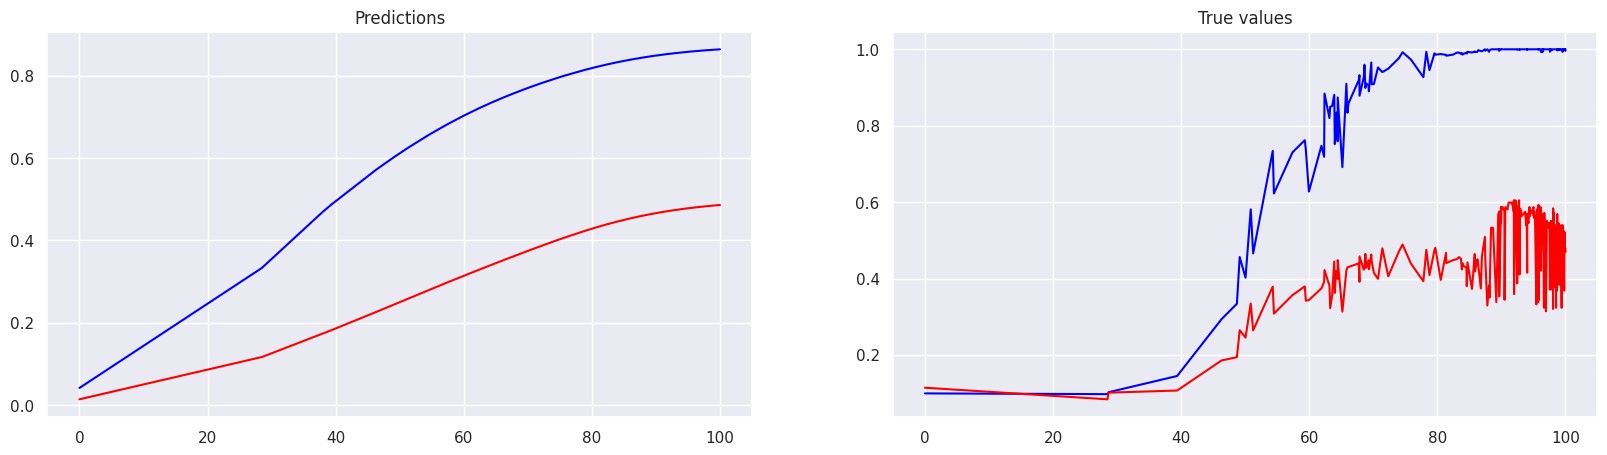

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.027295349165797234


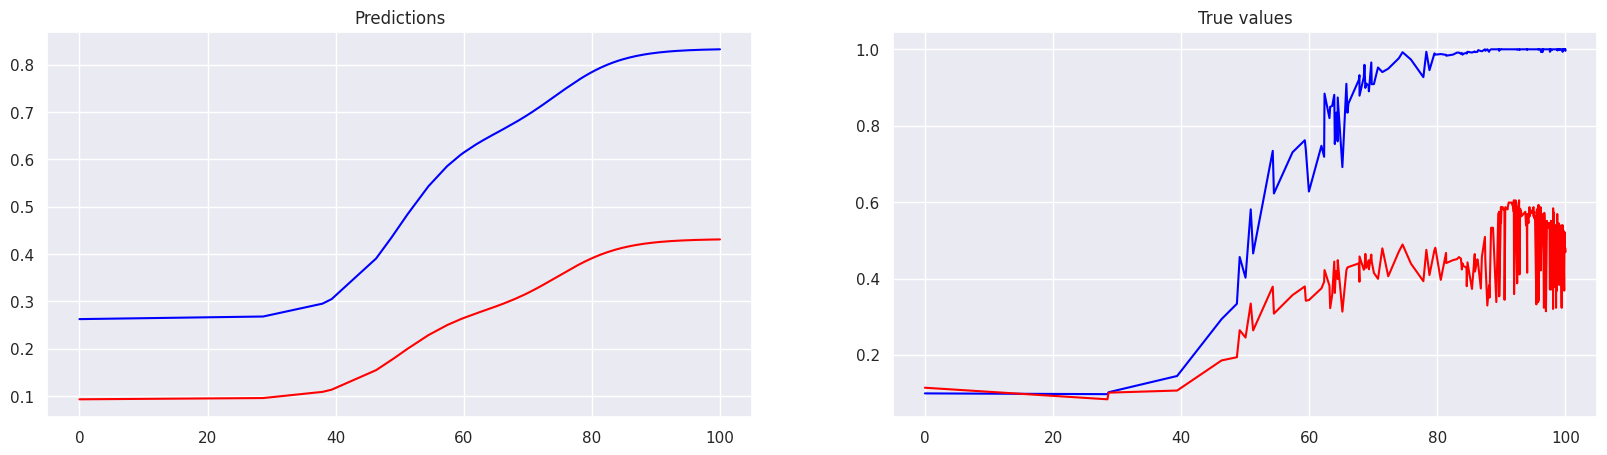

Epoch 1 - loss: 0.04233807697892189
Epoch 2 - loss: 0.016434835270047188
Epoch 3 - loss: 0.017488427460193634
Epoch 4 - loss: 0.018904440104961395
Epoch 5 - loss: 0.02002222277224064
Epoch 6 - loss: 0.020659156143665314
Epoch 7 - loss: 0.020827505737543106
Epoch 8 - loss: 0.020633505657315254
Epoch 9 - loss: 0.020205318927764893
Epoch 10 - loss: 0.019652940332889557
Epoch 11 - loss: 0.01906352862715721
Epoch 12 - loss: 0.01851528324186802
Epoch 13 - loss: 0.018076501786708832
Epoch 14 - loss: 0.017790254205465317
Epoch 15 - loss: 0.017661988735198975
Epoch 16 - loss: 0.017658010125160217
Epoch 17 - loss: 0.01771586760878563
Epoch 18 - loss: 0.01776360720396042
Epoch 19 - loss: 0.01774098351597786
Epoch 20 - loss: 0.017614547163248062
Epoch 21 - loss: 0.017382165417075157
Epoch 22 - loss: 0.017067115753889084
Epoch 23 - loss: 0.016706056892871857
Epoch 24 - loss: 0.01633581519126892
Epoch 25 - loss: 0.01598300039768219
Epoch 26 - loss: 0.015658579766750336
Epoch 27 - loss: 0.01535797957

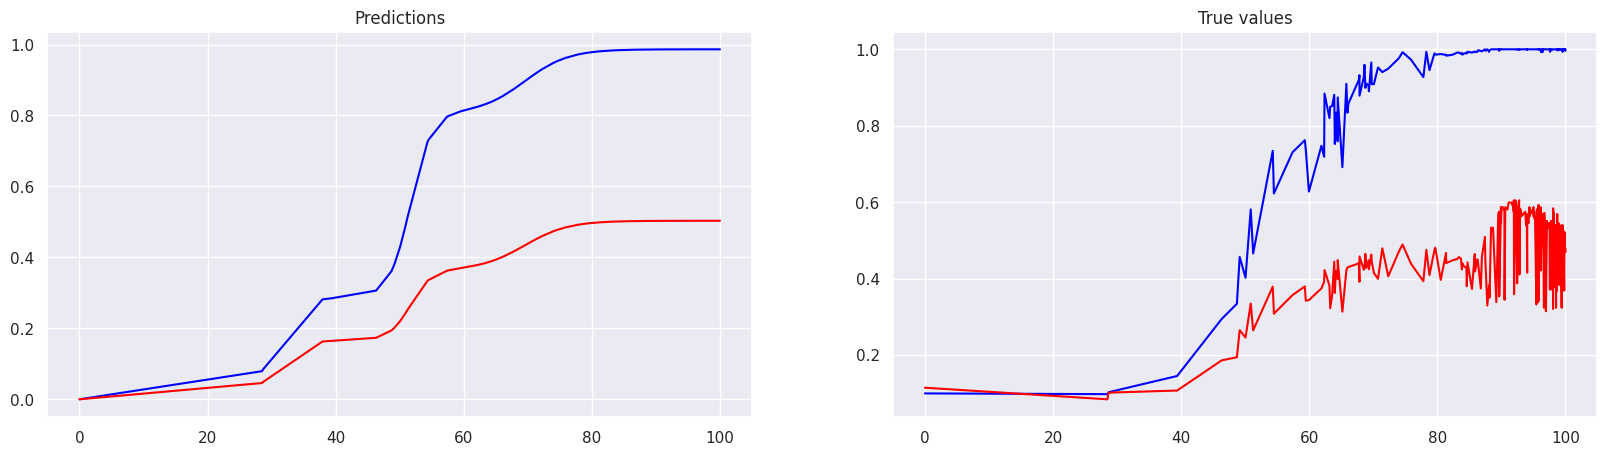

Epoch 101 - loss: 0.0060846139676868916
Epoch 102 - loss: 0.006074846722185612
Epoch 103 - loss: 0.006065095774829388
Epoch 104 - loss: 0.006055420730262995
Epoch 105 - loss: 0.006046327296644449
Epoch 106 - loss: 0.006037712562829256
Epoch 107 - loss: 0.006029132753610611
Epoch 108 - loss: 0.006020676344633102
Epoch 109 - loss: 0.006012685131281614
Epoch 110 - loss: 0.006005029194056988
Epoch 111 - loss: 0.0059974235482513905
Epoch 112 - loss: 0.005989989265799522
Epoch 113 - loss: 0.005982917733490467
Epoch 114 - loss: 0.005976041778922081
Epoch 115 - loss: 0.00596920121461153
Epoch 116 - loss: 0.005962540861219168
Epoch 117 - loss: 0.005956156179308891
Epoch 118 - loss: 0.005949893966317177
Epoch 119 - loss: 0.005943710450083017
Epoch 120 - loss: 0.005937731824815273
Epoch 121 - loss: 0.005931959021836519
Epoch 122 - loss: 0.0059262774884700775
Epoch 123 - loss: 0.0059207165613770485
Epoch 124 - loss: 0.005915362853556871
Epoch 125 - loss: 0.005910168867558241
Epoch 126 - loss: 0.00

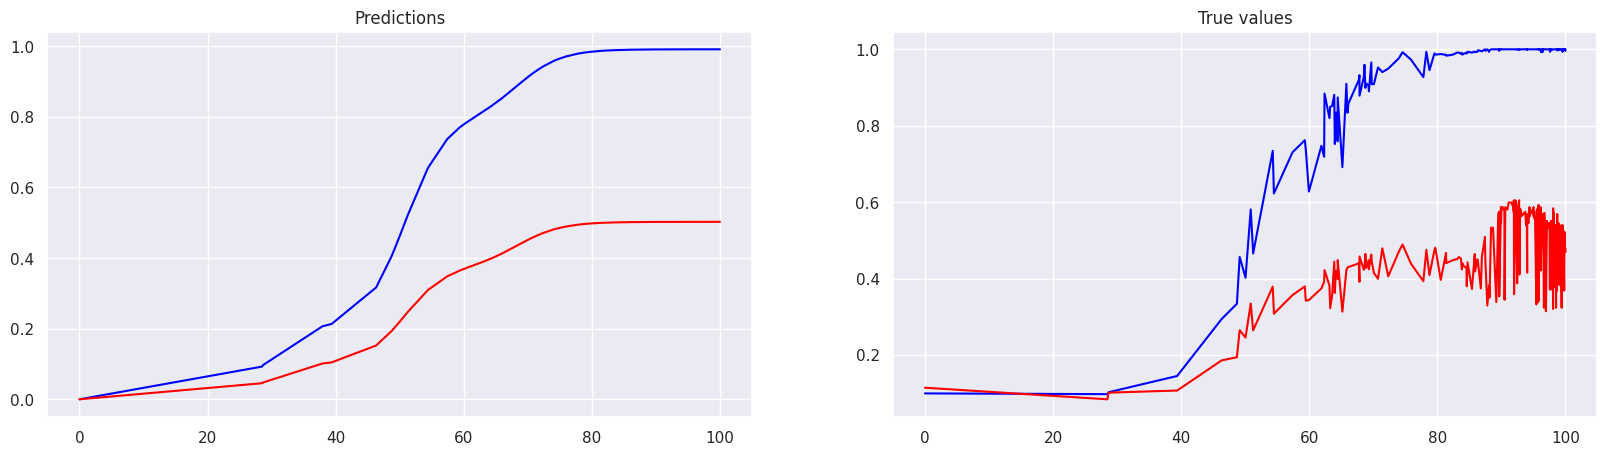

Epoch 201 - loss: 0.005753501784056425
Epoch 202 - loss: 0.0057526384480297565
Epoch 203 - loss: 0.005751785822212696
Epoch 204 - loss: 0.005750945769250393
Epoch 205 - loss: 0.005750116426497698
Epoch 206 - loss: 0.00574929965659976
Epoch 207 - loss: 0.005748492665588856
Epoch 208 - loss: 0.0057476963847875595
Epoch 209 - loss: 0.005746911745518446
Epoch 210 - loss: 0.005746136419475079
Epoch 211 - loss: 0.005745373200625181
Epoch 212 - loss: 0.005744617432355881
Epoch 213 - loss: 0.005743872839957476
Epoch 214 - loss: 0.005743138026446104
Epoch 215 - loss: 0.005742412060499191
Epoch 216 - loss: 0.005741695873439312
Epoch 217 - loss: 0.005740988068282604
Epoch 218 - loss: 0.00574029004201293
Epoch 219 - loss: 0.005739599000662565
Epoch 220 - loss: 0.005738919135183096
Epoch 221 - loss: 0.005738246254622936
Epoch 222 - loss: 0.005737581290304661
Epoch 223 - loss: 0.005736924707889557
Epoch 224 - loss: 0.005736276973038912
Epoch 225 - loss: 0.005735636688768864
Epoch 226 - loss: 0.00573

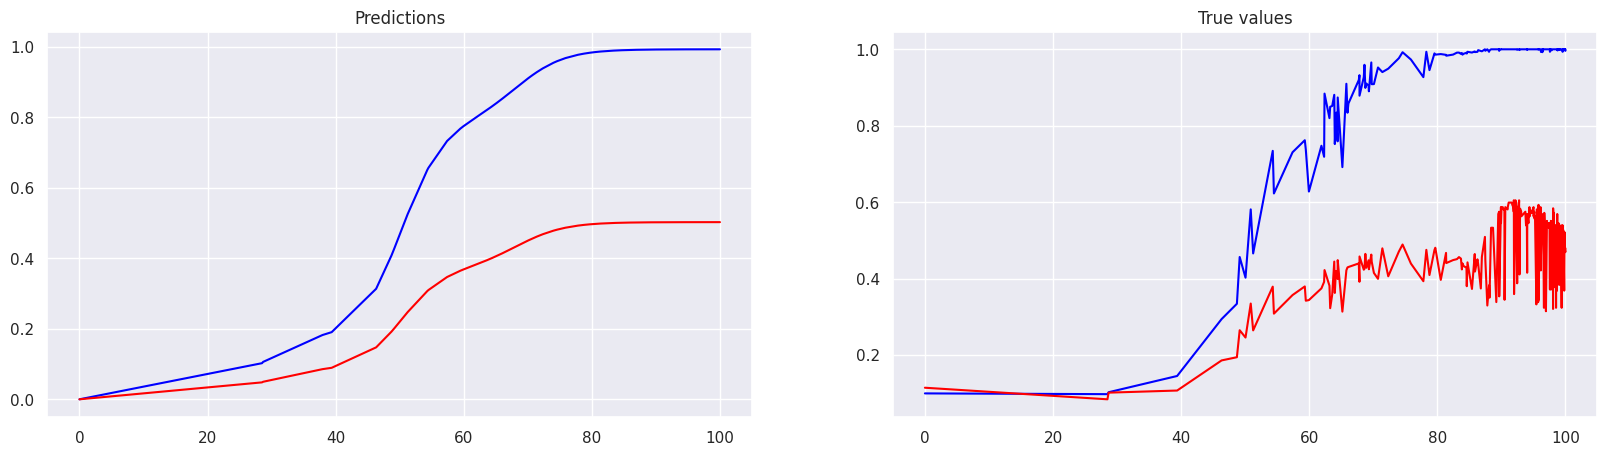

Epoch 301 - loss: 0.005702728405594826
Epoch 302 - loss: 0.0057024359703063965
Epoch 303 - loss: 0.005702146794646978
Epoch 304 - loss: 0.005701859947293997
Epoch 305 - loss: 0.005701575893908739
Epoch 306 - loss: 0.005701293703168631
Epoch 307 - loss: 0.005701013840734959
Epoch 308 - loss: 0.0057007367722690105
Epoch 309 - loss: 0.005700462497770786
Epoch 310 - loss: 0.005700189620256424
Epoch 311 - loss: 0.005699919071048498
Epoch 312 - loss: 0.005699650850147009
Epoch 313 - loss: 0.005699384491890669
Epoch 314 - loss: 0.00569912139326334
Epoch 315 - loss: 0.005698860622942448
Epoch 316 - loss: 0.005698600318282843
Epoch 317 - loss: 0.0056983428075909615
Epoch 318 - loss: 0.005698087625205517
Epoch 319 - loss: 0.005697833839803934
Epoch 320 - loss: 0.0056975833140313625
Epoch 321 - loss: 0.005697333719581366
Epoch 322 - loss: 0.005697086453437805
Epoch 323 - loss: 0.005696841515600681
Epoch 324 - loss: 0.005696597509086132
Epoch 325 - loss: 0.005696356296539307
Epoch 326 - loss: 0.00

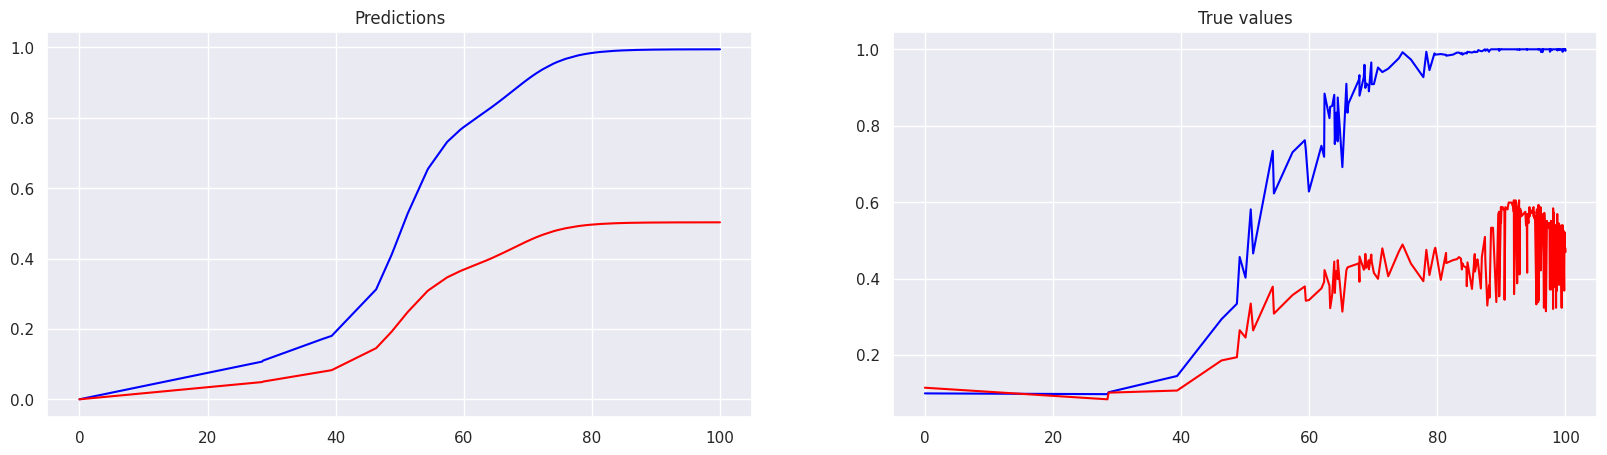

Epoch 401 - loss: 0.0056822760961949825
Epoch 402 - loss: 0.005682133138179779
Epoch 403 - loss: 0.005681992508471012
Epoch 404 - loss: 0.005681851878762245
Epoch 405 - loss: 0.0056817117147147655
Epoch 406 - loss: 0.005681573413312435
Epoch 407 - loss: 0.0056814346462488174
Epoch 408 - loss: 0.005681297741830349
Epoch 409 - loss: 0.005681161303073168
Epoch 410 - loss: 0.005681025329977274
Epoch 411 - loss: 0.005680890288203955
Epoch 412 - loss: 0.00568075617775321
Epoch 413 - loss: 0.00568062299862504
Epoch 414 - loss: 0.005680490750819445
Epoch 415 - loss: 0.005680358503013849
Epoch 416 - loss: 0.0056802271865308285
Epoch 417 - loss: 0.005680095870047808
Epoch 418 - loss: 0.005679967347532511
Epoch 419 - loss: 0.005679838825017214
Epoch 420 - loss: 0.005679710768163204
Epoch 421 - loss: 0.0056795827113091946
Epoch 422 - loss: 0.005679456517100334
Epoch 423 - loss: 0.005679330788552761
Epoch 424 - loss: 0.005679205060005188
Epoch 425 - loss: 0.005679080728441477
Epoch 426 - loss: 0.00

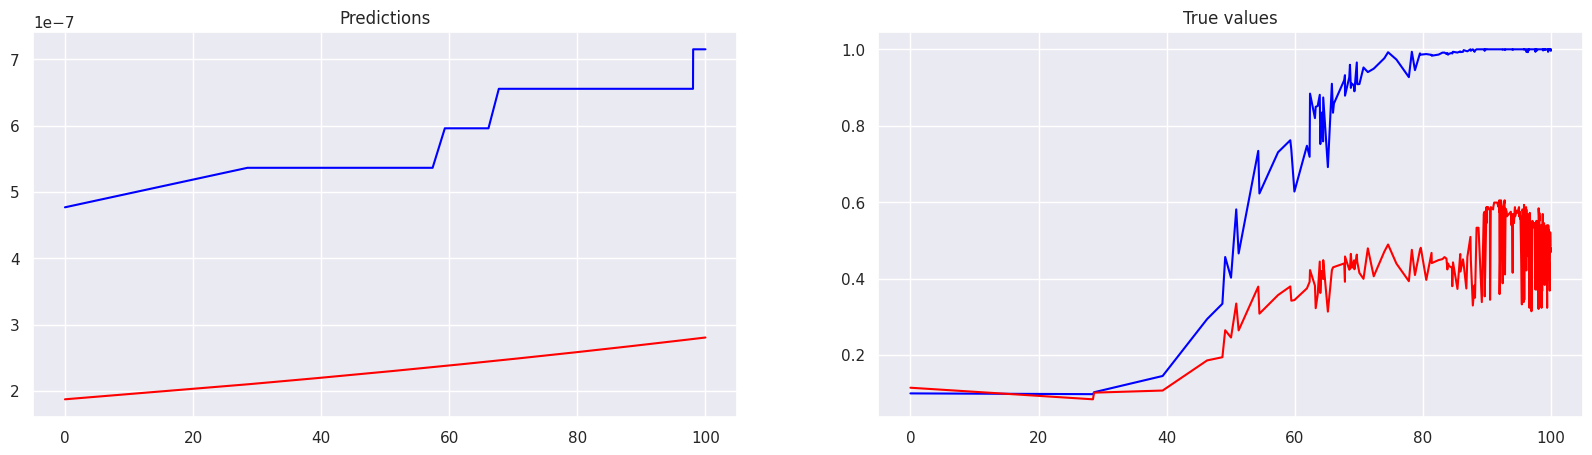

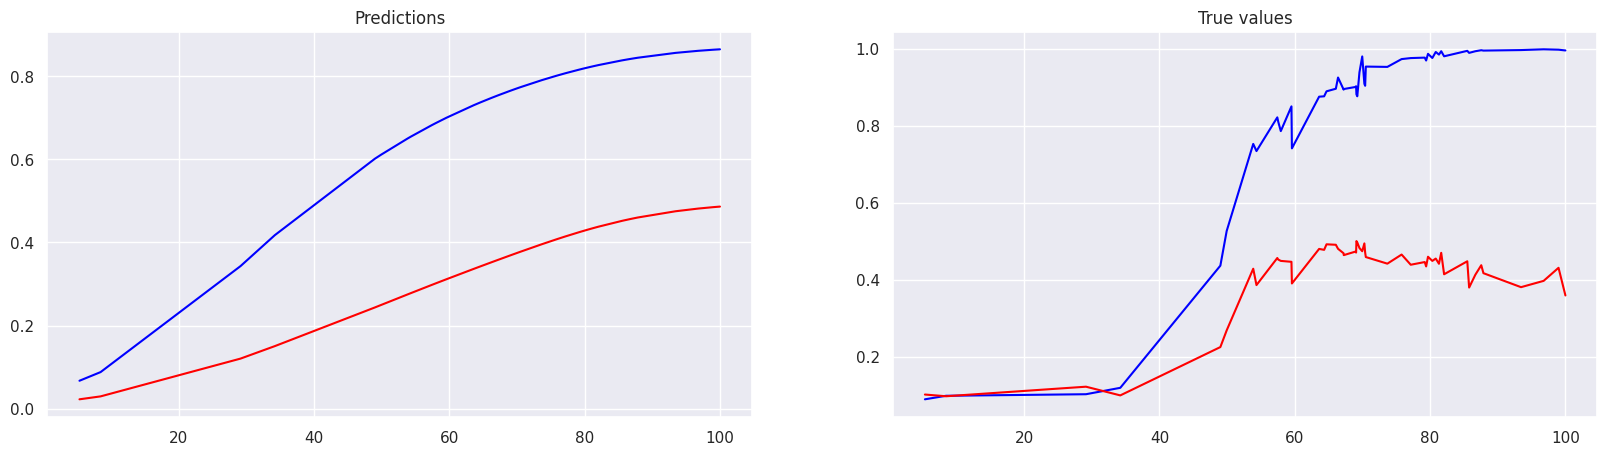

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.03156862035393715


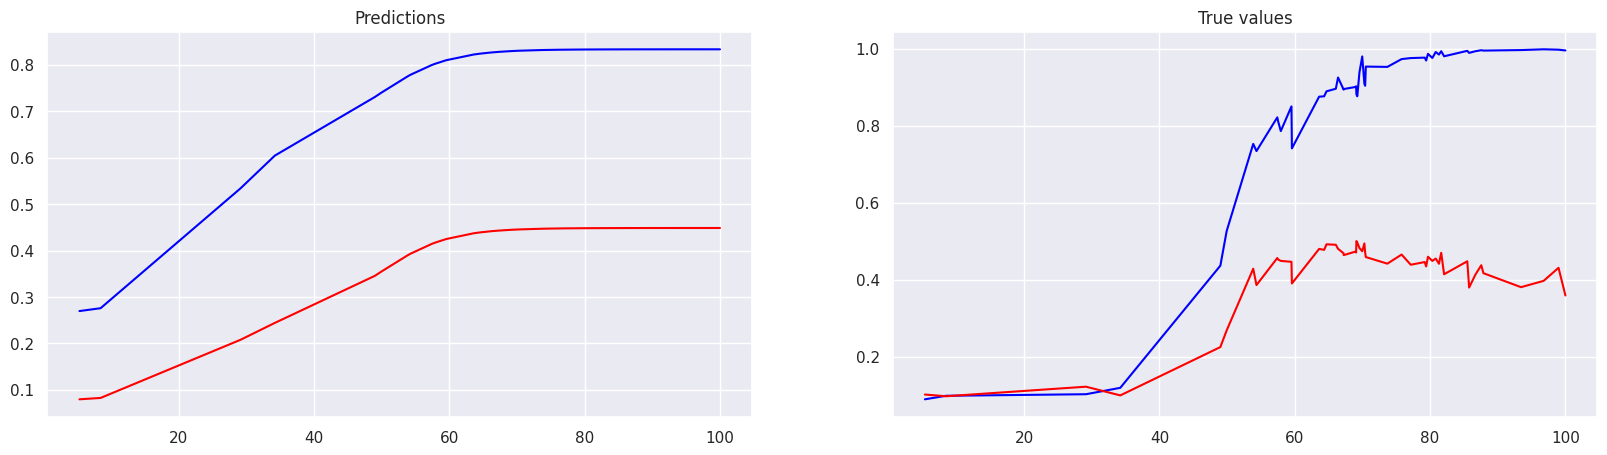

Epoch 1 - loss: 0.026877054944634438
Epoch 2 - loss: 0.01818348653614521
Epoch 3 - loss: 0.017054378986358643
Epoch 4 - loss: 0.016217723488807678
Epoch 5 - loss: 0.015472529456019402
Epoch 6 - loss: 0.01645026169717312
Epoch 7 - loss: 0.01655708998441696
Epoch 8 - loss: 0.017565960064530373
Epoch 9 - loss: 0.017035936936736107
Epoch 10 - loss: 0.015546495094895363
Epoch 11 - loss: 0.015176376327872276
Epoch 12 - loss: 0.015189245343208313
Epoch 13 - loss: 0.013720232993364334
Epoch 14 - loss: 0.013415748253464699
Epoch 15 - loss: 0.012981919571757317
Epoch 16 - loss: 0.012275537475943565
Epoch 17 - loss: 0.01144371647387743
Epoch 18 - loss: 0.01066085696220398
Epoch 19 - loss: 0.010065503418445587
Epoch 20 - loss: 0.009692935273051262
Epoch 21 - loss: 0.009370051324367523
Epoch 22 - loss: 0.008873735554516315
Epoch 23 - loss: 0.008277873508632183
Epoch 24 - loss: 0.007744273170828819
Epoch 25 - loss: 0.007306347601115704
Epoch 26 - loss: 0.0069392030127346516
Epoch 27 - loss: 0.006616

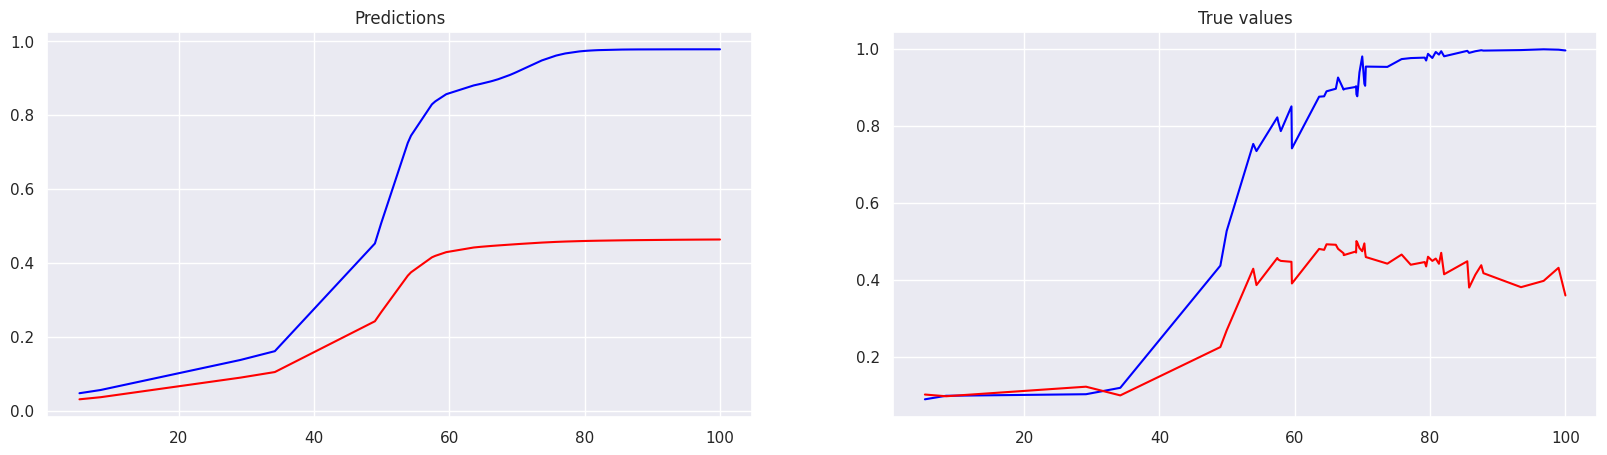

Epoch 101 - loss: 0.002357575111091137
Epoch 102 - loss: 0.0023481426760554314
Epoch 103 - loss: 0.002339243423193693
Epoch 104 - loss: 0.002330719493329525
Epoch 105 - loss: 0.002322475891560316
Epoch 106 - loss: 0.0023145906161516905
Epoch 107 - loss: 0.002306964946910739
Epoch 108 - loss: 0.0022994920145720243
Epoch 109 - loss: 0.002292232820764184
Epoch 110 - loss: 0.0022851540707051754
Epoch 111 - loss: 0.0022781682200729847
Epoch 112 - loss: 0.002271318342536688
Epoch 113 - loss: 0.002264615148305893
Epoch 114 - loss: 0.0022579925134778023
Epoch 115 - loss: 0.002251487458124757
Epoch 116 - loss: 0.0022451302502304316
Epoch 117 - loss: 0.0022388852667063475
Epoch 118 - loss: 0.0022327820770442486
Epoch 119 - loss: 0.002226849552243948
Epoch 120 - loss: 0.0022210548631846905
Epoch 121 - loss: 0.0022154077887535095
Epoch 122 - loss: 0.0022099183406680822
Epoch 123 - loss: 0.002204547170549631
Epoch 124 - loss: 0.0021992933470755816
Epoch 125 - loss: 0.0021941540762782097
Epoch 126 -

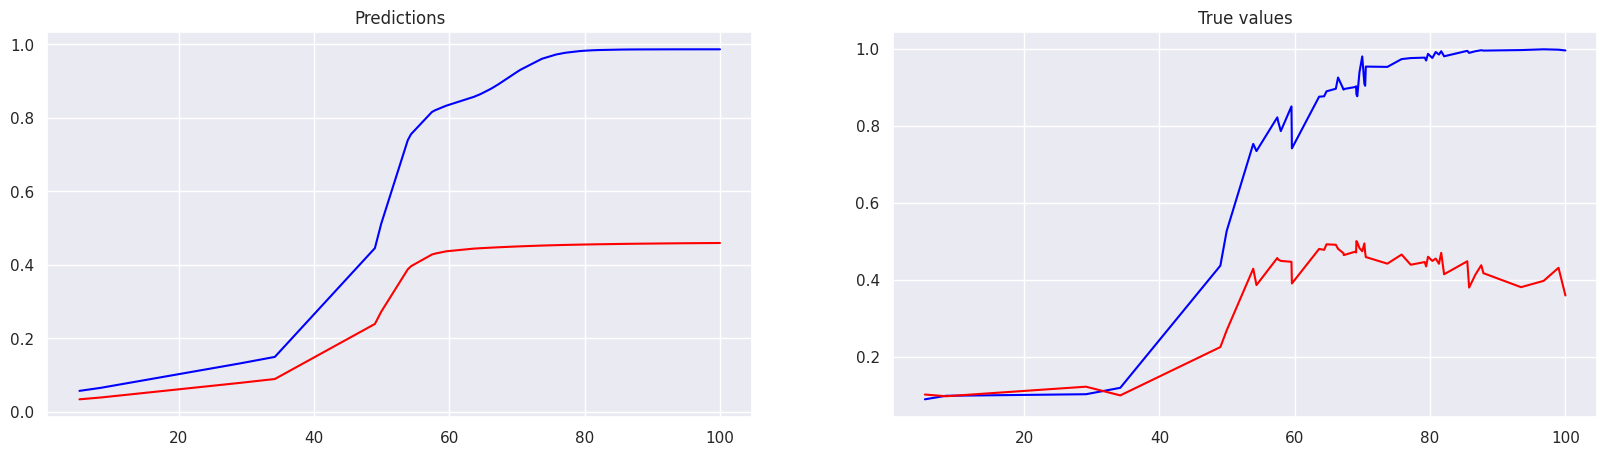

Epoch 201 - loss: 0.0019519906491041183
Epoch 202 - loss: 0.0019500625785440207
Epoch 203 - loss: 0.0019481551134958863
Epoch 204 - loss: 0.001946267206221819
Epoch 205 - loss: 0.0019444008357822895
Epoch 206 - loss: 0.0019425528589636087
Epoch 207 - loss: 0.0019407251384109259
Epoch 208 - loss: 0.0019389165099710226
Epoch 209 - loss: 0.0019371272064745426
Epoch 210 - loss: 0.001935357227921486
Epoch 211 - loss: 0.0019336052937433124
Epoch 212 - loss: 0.0019318704726174474
Epoch 213 - loss: 0.0019301557913422585
Epoch 214 - loss: 0.0019284584559500217
Epoch 215 - loss: 0.001926778582856059
Epoch 216 - loss: 0.0019251159392297268
Epoch 217 - loss: 0.0019234723877161741
Epoch 218 - loss: 0.0019218451343476772
Epoch 219 - loss: 0.0019202344119548798
Epoch 220 - loss: 0.0019186416175216436
Epoch 221 - loss: 0.0019170655868947506
Epoch 222 - loss: 0.0019155048066750169
Epoch 223 - loss: 0.0019139617215842009
Epoch 224 - loss: 0.0019124343525618315
Epoch 225 - loss: 0.0019109246786683798
Epo

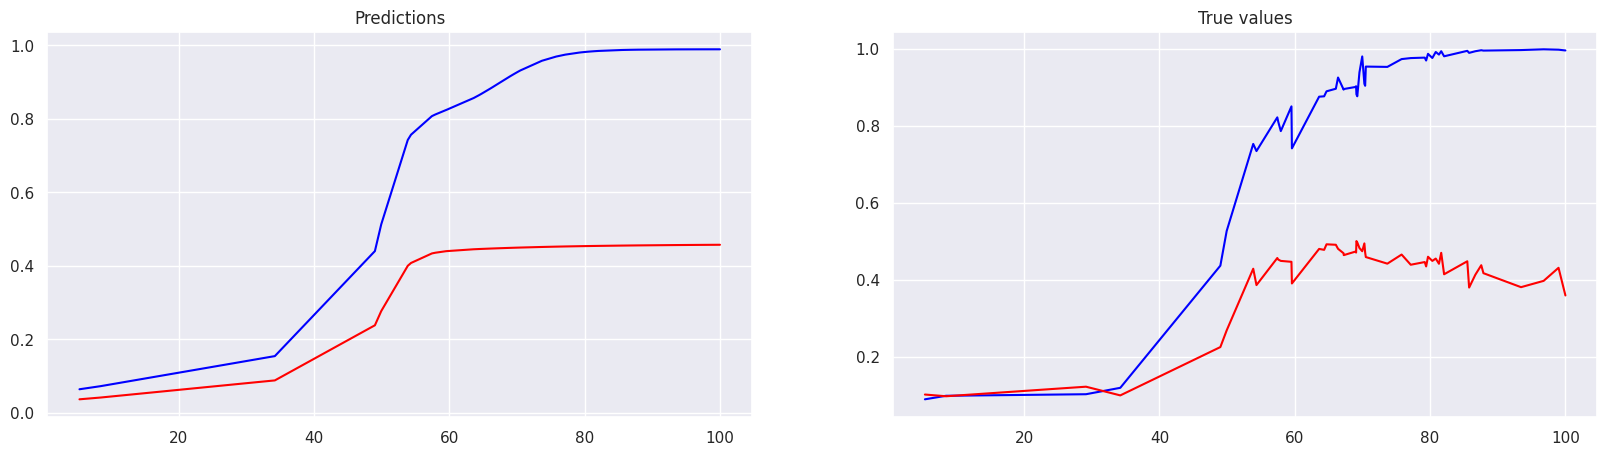

Epoch 301 - loss: 0.001832709414884448
Epoch 302 - loss: 0.001832017209380865
Epoch 303 - loss: 0.0018313301261514425
Epoch 304 - loss: 0.0018306492129340768
Epoch 305 - loss: 0.0018299741204828024
Epoch 306 - loss: 0.0018293040338903666
Epoch 307 - loss: 0.001828639768064022
Epoch 308 - loss: 0.0018279798096045852
Epoch 309 - loss: 0.0018273266032338142
Epoch 310 - loss: 0.0018266765400767326
Epoch 311 - loss: 0.0018260329961776733
Epoch 312 - loss: 0.0018253937596455216
Epoch 313 - loss: 0.001824759878218174
Epoch 314 - loss: 0.0018241305369883776
Epoch 315 - loss: 0.0018235056195408106
Epoch 316 - loss: 0.0018228853587061167
Epoch 317 - loss: 0.0018222704529762268
Epoch 318 - loss: 0.0018216597381979227
Epoch 319 - loss: 0.0018210529815405607
Epoch 320 - loss: 0.0018204508814960718
Epoch 321 - loss: 0.0018198536708950996
Epoch 322 - loss: 0.0018192597199231386
Epoch 323 - loss: 0.0018186699599027634
Epoch 324 - loss: 0.0018180860206484795
Epoch 325 - loss: 0.0018175048753619194
Epoc

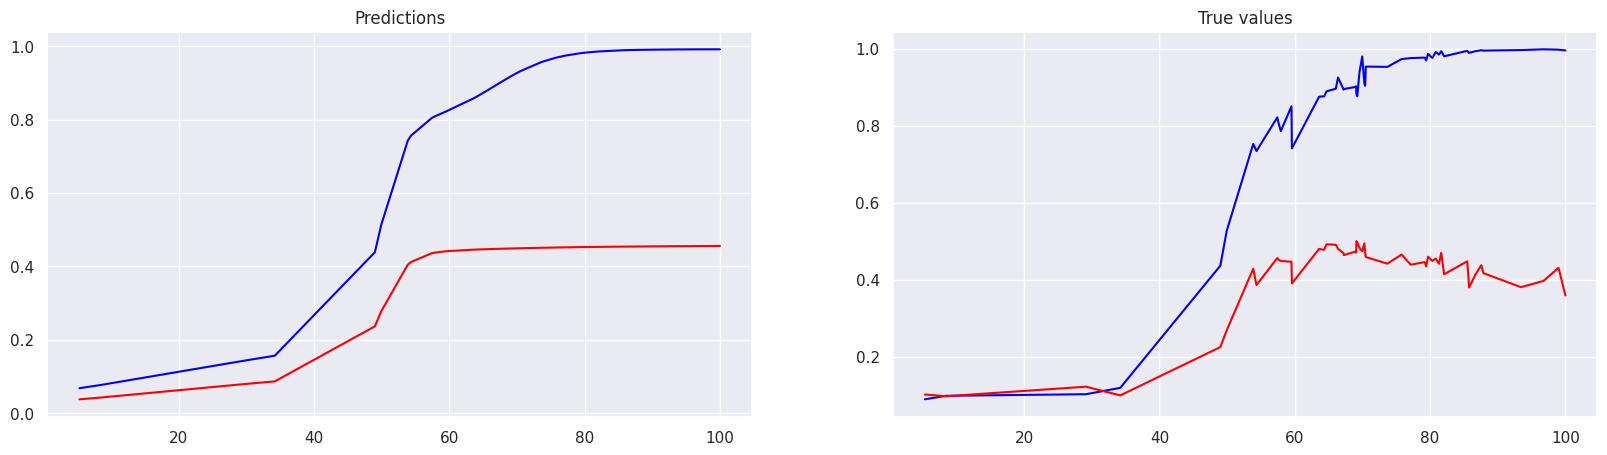

Epoch 401 - loss: 0.0017819488421082497
Epoch 402 - loss: 0.0017815622268244624
Epoch 403 - loss: 0.0017811767756938934
Epoch 404 - loss: 0.0017807928379625082
Epoch 405 - loss: 0.0017804097151383758
Epoch 406 - loss: 0.001780029502697289
Epoch 407 - loss: 0.0017796496395021677
Epoch 408 - loss: 0.0017792719881981611
Epoch 409 - loss: 0.0017788952682167292
Epoch 410 - loss: 0.0017785199452191591
Epoch 411 - loss: 0.0017781462520360947
Epoch 412 - loss: 0.0017777739558368921
Epoch 413 - loss: 0.0017774025909602642
Epoch 414 - loss: 0.0017770330887287855
Epoch 415 - loss: 0.0017766640521585941
Epoch 416 - loss: 0.001776297576725483
Epoch 417 - loss: 0.0017759313341230154
Epoch 418 - loss: 0.0017755671869963408
Epoch 419 - loss: 0.001775203738361597
Epoch 420 - loss: 0.001774841919541359
Epoch 421 - loss: 0.0017744810320436954
Epoch 422 - loss: 0.0017741217743605375
Epoch 423 - loss: 0.0017737632151693106
Epoch 424 - loss: 0.0017734053544700146
Epoch 425 - loss: 0.0017730508698150516
Epoc

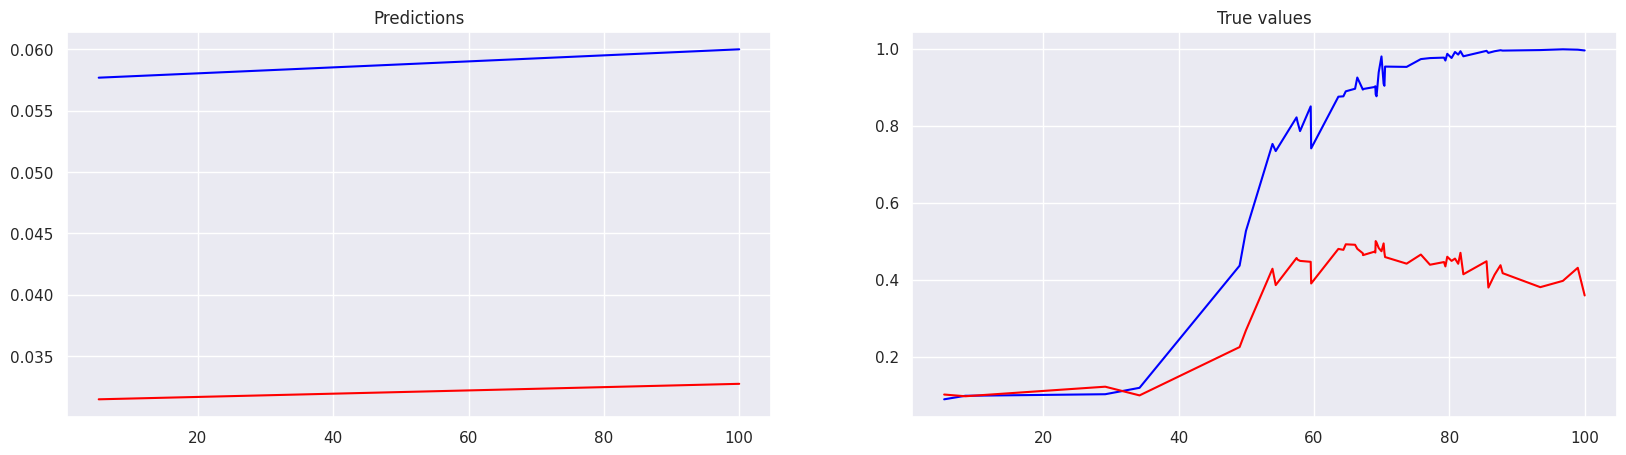

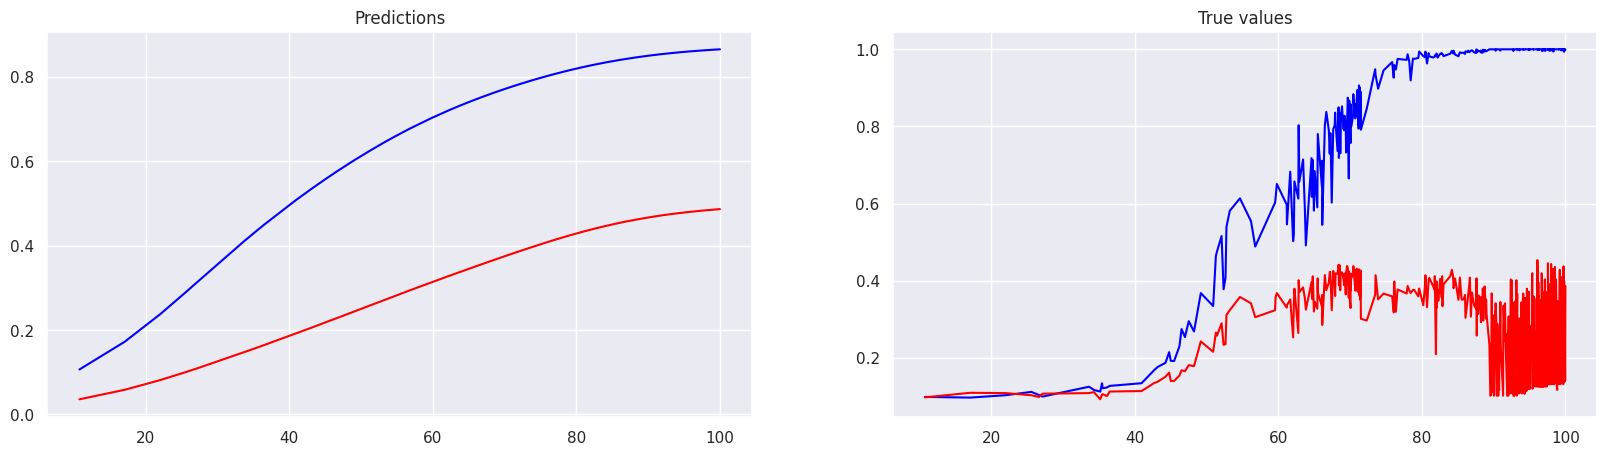

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.06713953614234924


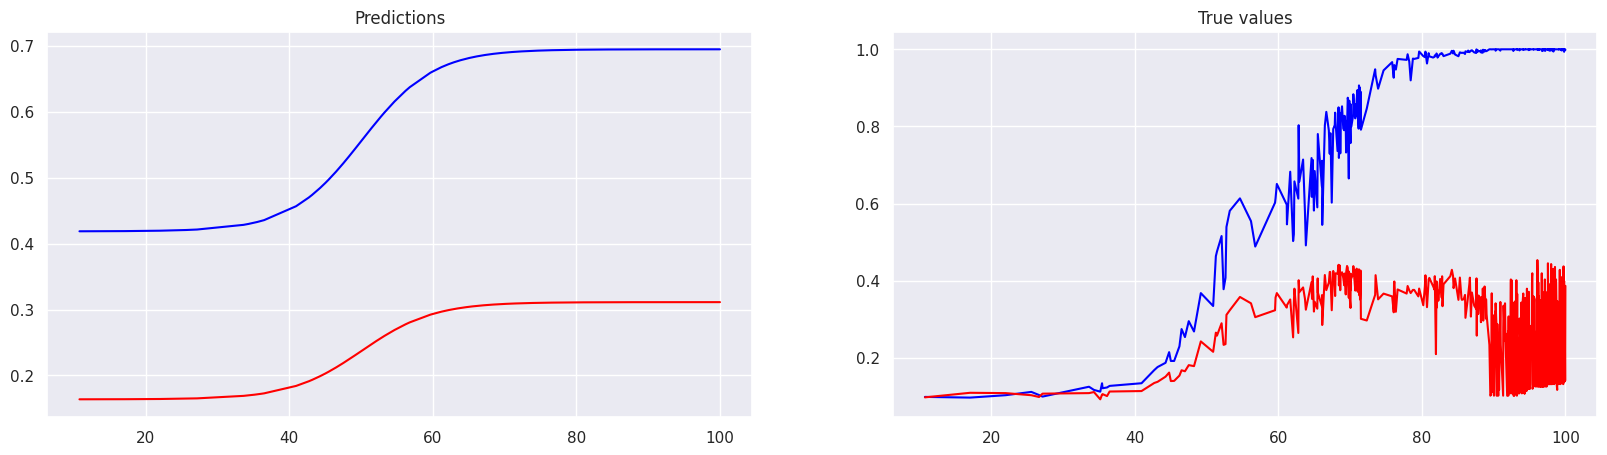

Epoch 1 - loss: 0.08898729085922241
Epoch 2 - loss: 0.05979643762111664
Epoch 3 - loss: 0.06275251507759094
Epoch 4 - loss: 0.06347602605819702
Epoch 5 - loss: 0.06264461576938629
Epoch 6 - loss: 0.06098976731300354
Epoch 7 - loss: 0.05895423889160156
Epoch 8 - loss: 0.056783631443977356
Epoch 9 - loss: 0.0545915886759758
Epoch 10 - loss: 0.05240888148546219
Epoch 11 - loss: 0.05022604763507843
Epoch 12 - loss: 0.04802864417433739
Epoch 13 - loss: 0.04582023620605469
Epoch 14 - loss: 0.043631695210933685
Epoch 15 - loss: 0.0415198989212513
Epoch 16 - loss: 0.039558738470077515
Epoch 17 - loss: 0.03782077878713608
Epoch 18 - loss: 0.03634823113679886
Epoch 19 - loss: 0.035127975046634674
Epoch 20 - loss: 0.03409960865974426
Epoch 21 - loss: 0.03319643437862396
Epoch 22 - loss: 0.032379038631916046
Epoch 23 - loss: 0.031639132648706436
Epoch 24 - loss: 0.030987180769443512
Epoch 25 - loss: 0.030435871332883835
Epoch 26 - loss: 0.0299835205078125
Epoch 27 - loss: 0.029606901109218597
Epoc

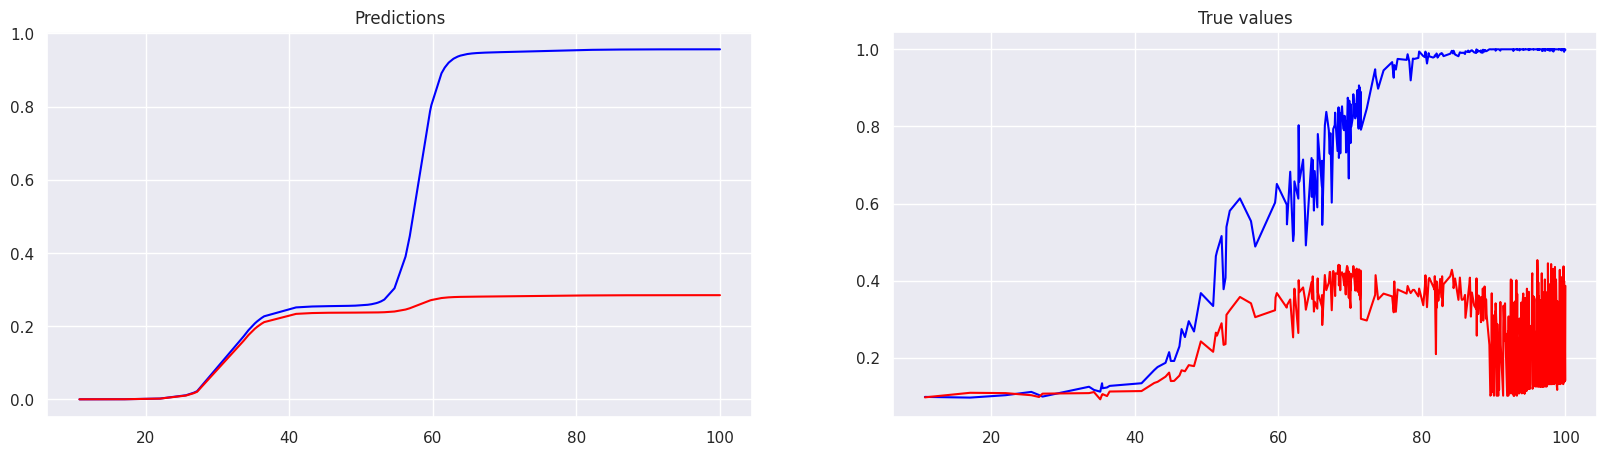

Epoch 101 - loss: 0.021819792687892914
Epoch 102 - loss: 0.021781157702207565
Epoch 103 - loss: 0.021741311997175217
Epoch 104 - loss: 0.021700559183955193
Epoch 105 - loss: 0.021658118814229965
Epoch 106 - loss: 0.021612804383039474
Epoch 107 - loss: 0.021563820540905
Epoch 108 - loss: 0.021511176601052284
Epoch 109 - loss: 0.021455468609929085
Epoch 110 - loss: 0.021397288888692856
Epoch 111 - loss: 0.02133675292134285
Epoch 112 - loss: 0.021273422986268997
Epoch 113 - loss: 0.021206699311733246
Epoch 114 - loss: 0.021136244758963585
Epoch 115 - loss: 0.021062180399894714
Epoch 116 - loss: 0.020984910428524017
Epoch 117 - loss: 0.0209047868847847
Epoch 118 - loss: 0.020821884274482727
Epoch 119 - loss: 0.02073603868484497
Epoch 120 - loss: 0.020647086203098297
Epoch 121 - loss: 0.020555049180984497
Epoch 122 - loss: 0.020460214465856552
Epoch 123 - loss: 0.020362984389066696
Epoch 124 - loss: 0.020263714715838432
Epoch 125 - loss: 0.02016262710094452
Epoch 126 - loss: 0.0200598873198

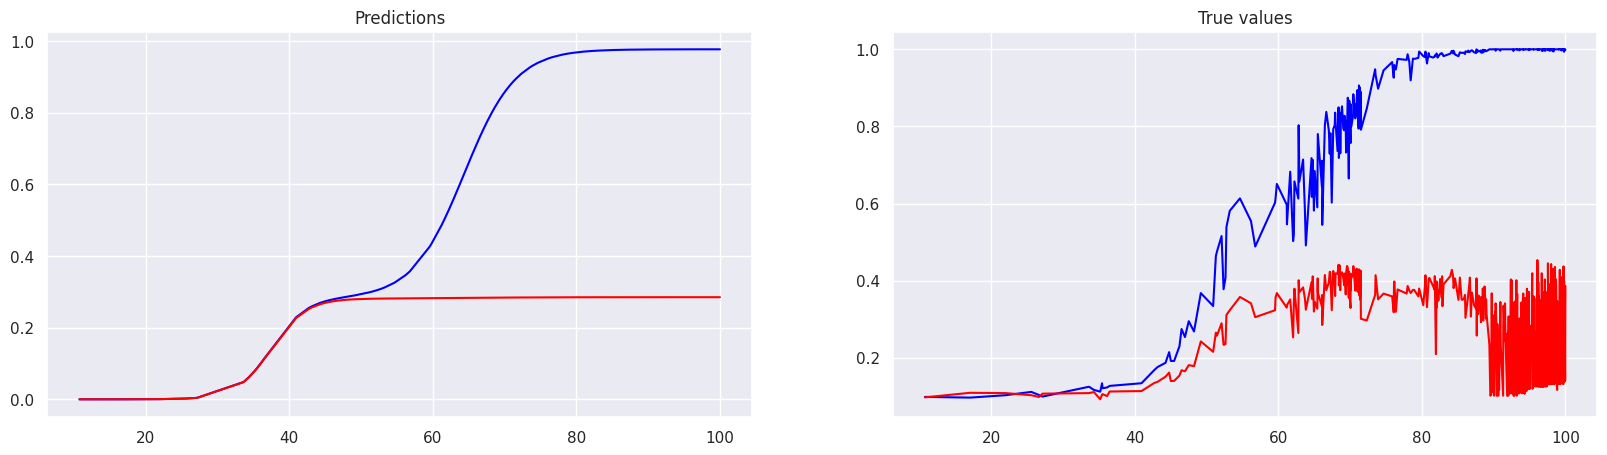

Epoch 201 - loss: 0.014577401801943779
Epoch 202 - loss: 0.014499939046800137
Epoch 203 - loss: 0.014424953609704971
Epoch 204 - loss: 0.014353040605783463
Epoch 205 - loss: 0.014284828677773476
Epoch 206 - loss: 0.014220950193703175
Epoch 207 - loss: 0.014162028208374977
Epoch 208 - loss: 0.01410860288888216
Epoch 209 - loss: 0.014061096124351025
Epoch 210 - loss: 0.014019716531038284
Epoch 211 - loss: 0.013984392397105694
Epoch 212 - loss: 0.013954706490039825
Epoch 213 - loss: 0.01392985600978136
Epoch 214 - loss: 0.013908683322370052
Epoch 215 - loss: 0.013889752328395844
Epoch 216 - loss: 0.013871557079255581
Epoch 217 - loss: 0.013852713629603386
Epoch 218 - loss: 0.013832220807671547
Epoch 219 - loss: 0.013809628784656525
Epoch 220 - loss: 0.01378507912158966
Epoch 221 - loss: 0.013759244233369827
Epoch 222 - loss: 0.013733124360442162
Epoch 223 - loss: 0.013707825914025307
Epoch 224 - loss: 0.013684311881661415
Epoch 225 - loss: 0.013663275167346
Epoch 226 - loss: 0.01364504359

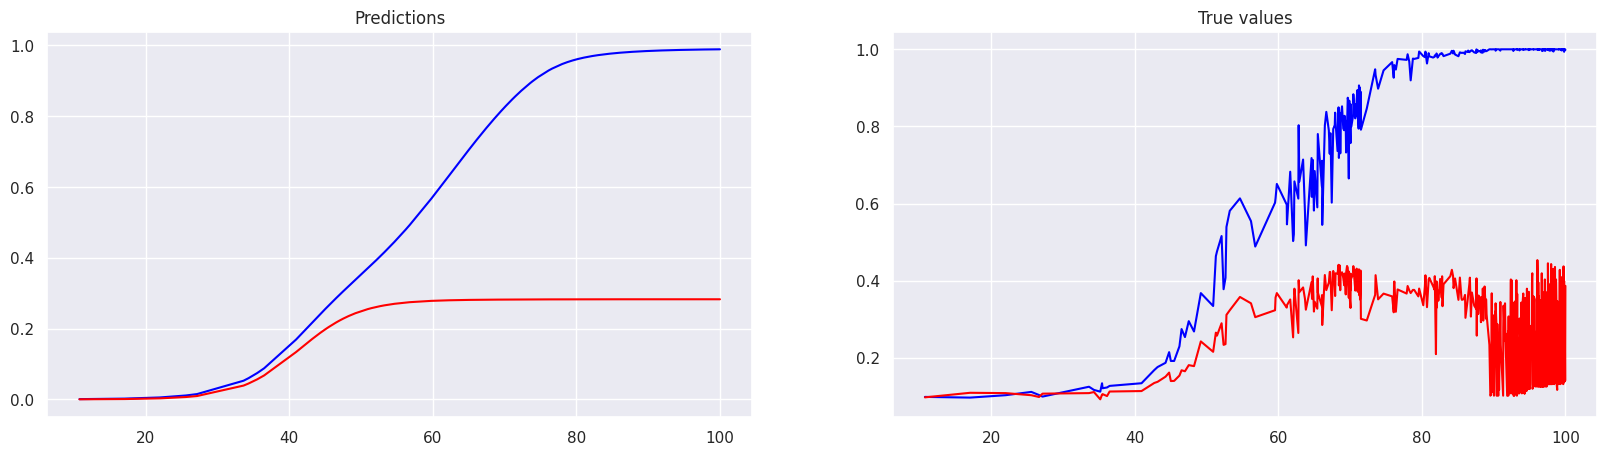

Epoch 301 - loss: 0.013111032545566559
Epoch 302 - loss: 0.013108299113810062
Epoch 303 - loss: 0.013105666264891624
Epoch 304 - loss: 0.013103128410875797
Epoch 305 - loss: 0.013100685551762581
Epoch 306 - loss: 0.013098329305648804
Epoch 307 - loss: 0.013096051290631294
Epoch 308 - loss: 0.013093854300677776
Epoch 309 - loss: 0.013091725297272205
Epoch 310 - loss: 0.013089665211737156
Epoch 311 - loss: 0.013087667524814606
Epoch 312 - loss: 0.013085726648569107
Epoch 313 - loss: 0.013083837926387787
Epoch 314 - loss: 0.013081998564302921
Epoch 315 - loss: 0.013080207630991936
Epoch 316 - loss: 0.013078455813229084
Epoch 317 - loss: 0.01307674404233694
Epoch 318 - loss: 0.013075070455670357
Epoch 319 - loss: 0.013073431327939034
Epoch 320 - loss: 0.013071823865175247
Epoch 321 - loss: 0.013070249930024147
Epoch 322 - loss: 0.013068702071905136
Epoch 323 - loss: 0.013067182153463364
Epoch 324 - loss: 0.01306568831205368
Epoch 325 - loss: 0.013064219616353512
Epoch 326 - loss: 0.0130627

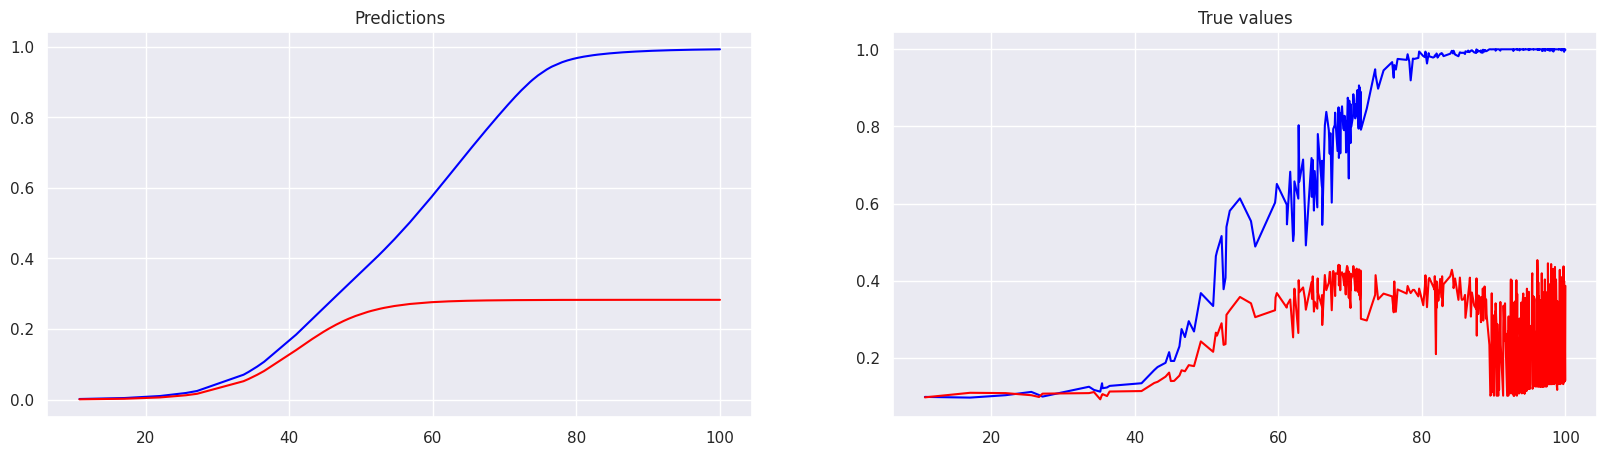

Epoch 401 - loss: 0.012990040704607964
Epoch 402 - loss: 0.012989353388547897
Epoch 403 - loss: 0.01298866979777813
Epoch 404 - loss: 0.01298799179494381
Epoch 405 - loss: 0.012987317517399788
Epoch 406 - loss: 0.01298664789646864
Epoch 407 - loss: 0.012985983863472939
Epoch 408 - loss: 0.01298532634973526
Epoch 409 - loss: 0.012984668835997581
Epoch 410 - loss: 0.01298401691019535
Epoch 411 - loss: 0.012983371503651142
Epoch 412 - loss: 0.012982727959752083
Epoch 413 - loss: 0.01298209186643362
Epoch 414 - loss: 0.012981457635760307
Epoch 415 - loss: 0.012980827130377293
Epoch 416 - loss: 0.012980202212929726
Epoch 417 - loss: 0.012979583814740181
Epoch 418 - loss: 0.012978965416550636
Epoch 419 - loss: 0.012978351674973965
Epoch 420 - loss: 0.01297774352133274
Epoch 421 - loss: 0.01297713816165924
Epoch 422 - loss: 0.012976537458598614
Epoch 423 - loss: 0.012975940480828285
Epoch 424 - loss: 0.012975347228348255
Epoch 425 - loss: 0.012974758632481098
Epoch 426 - loss: 0.0129741728305

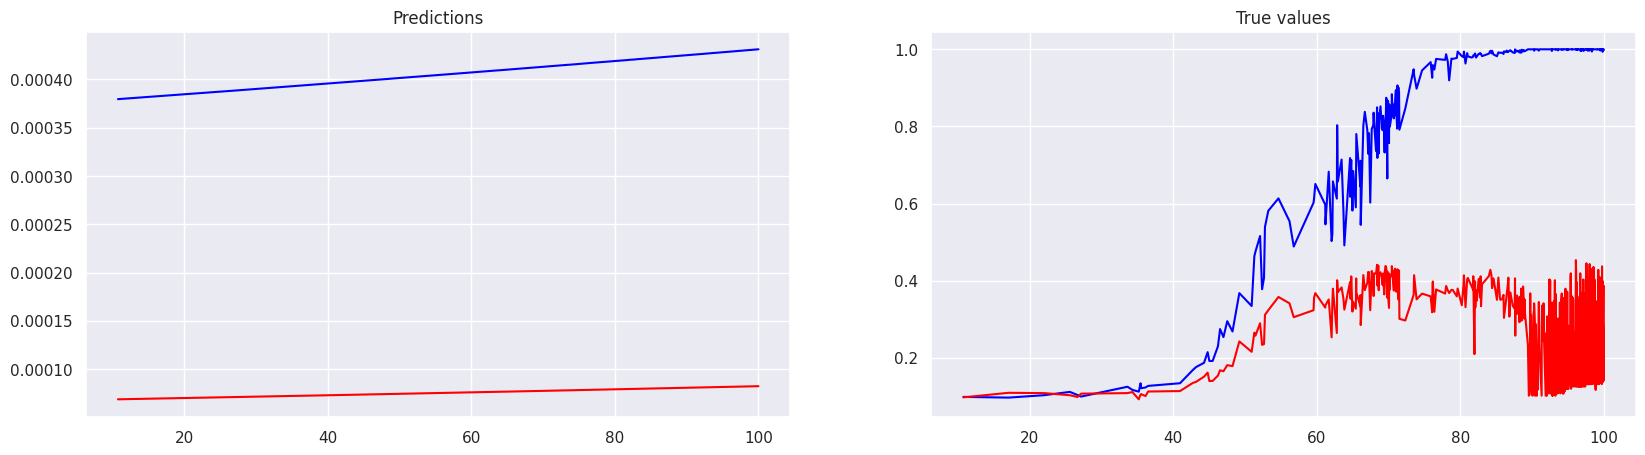

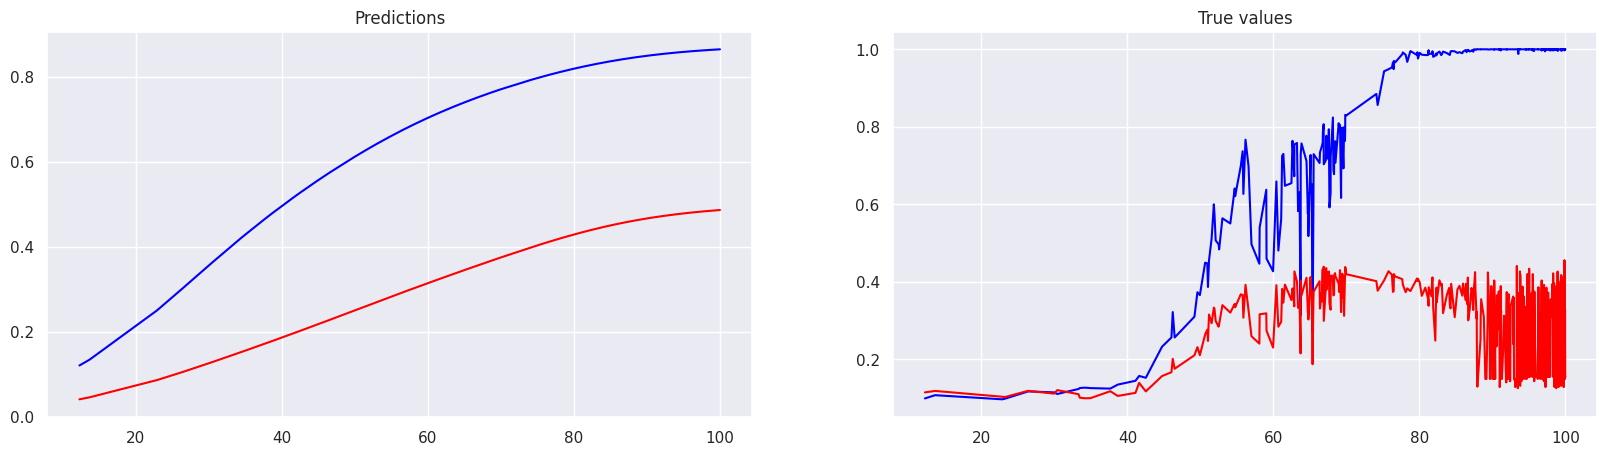

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.06139448285102844


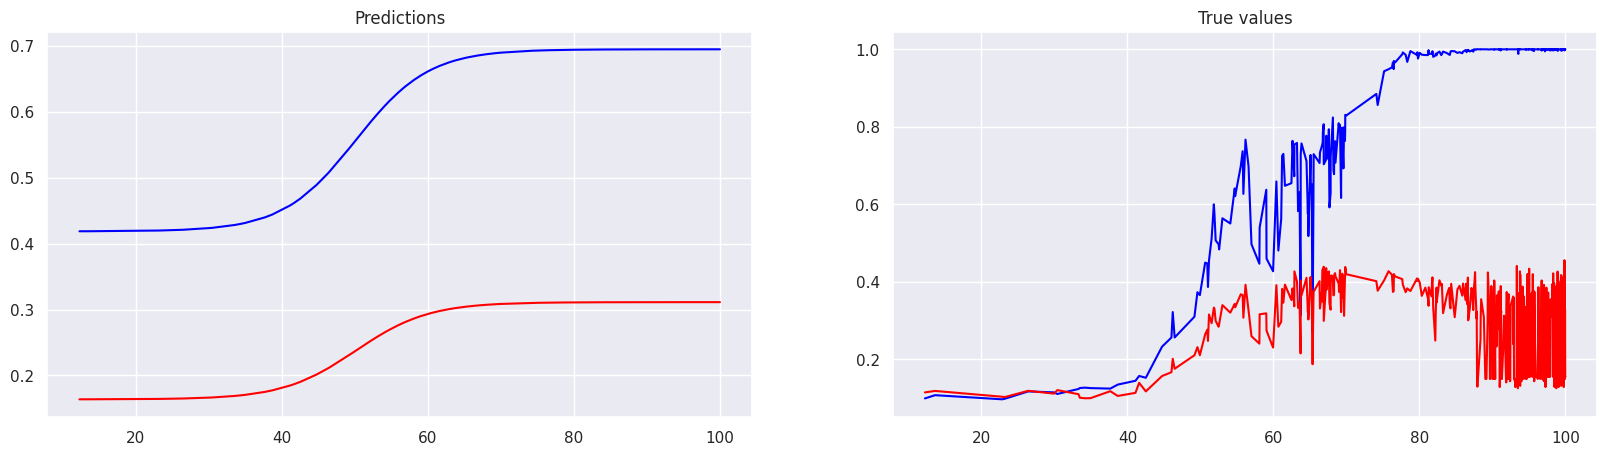

Epoch 1 - loss: 0.08569548279047012
Epoch 2 - loss: 0.055699191987514496
Epoch 3 - loss: 0.05867598205804825
Epoch 4 - loss: 0.05965474992990494
Epoch 5 - loss: 0.05912511795759201
Epoch 6 - loss: 0.05776314437389374
Epoch 7 - loss: 0.0560382679104805
Epoch 8 - loss: 0.05423159897327423
Epoch 9 - loss: 0.05247683823108673
Epoch 10 - loss: 0.0508023276925087
Epoch 11 - loss: 0.049174945801496506
Epoch 12 - loss: 0.047544315457344055
Epoch 13 - loss: 0.045877497643232346
Epoch 14 - loss: 0.044174738228321075
Epoch 15 - loss: 0.04246491938829422
Epoch 16 - loss: 0.04078749567270279
Epoch 17 - loss: 0.0391724593937397
Epoch 18 - loss: 0.037629641592502594
Epoch 19 - loss: 0.036152854561805725
Epoch 20 - loss: 0.03473438695073128
Epoch 21 - loss: 0.033377956598997116
Epoch 22 - loss: 0.032101359218358994
Epoch 23 - loss: 0.03092934563755989
Epoch 24 - loss: 0.029883019626140594
Epoch 25 - loss: 0.02897176891565323
Epoch 26 - loss: 0.028189929202198982
Epoch 27 - loss: 0.027517907321453094
E

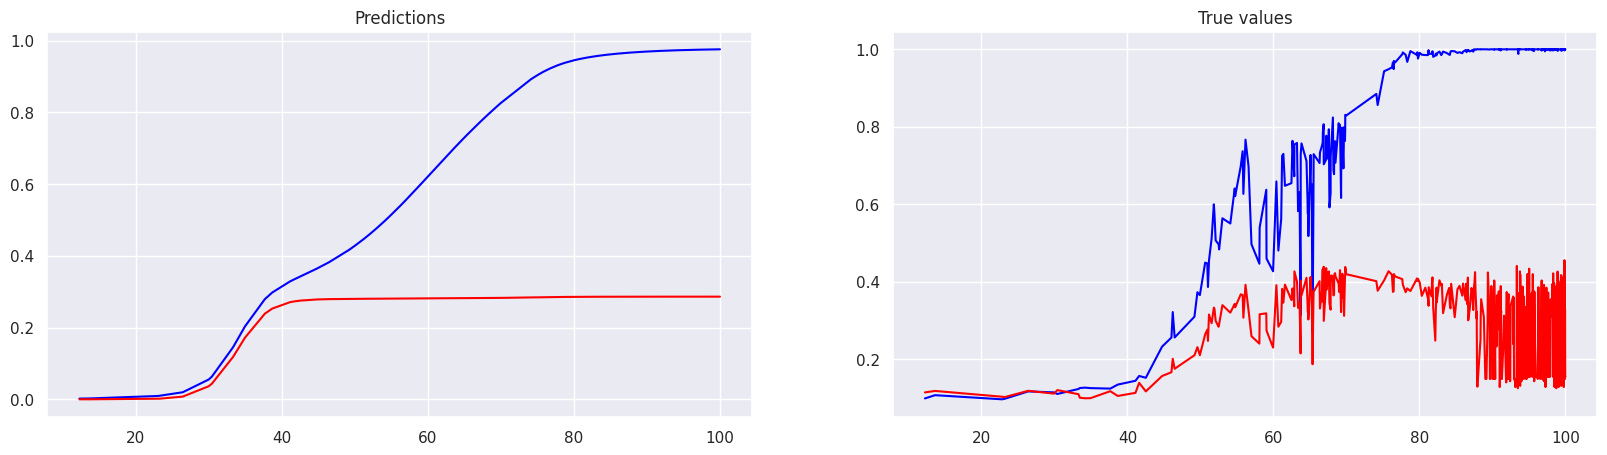

Epoch 101 - loss: 0.013784892857074738
Epoch 102 - loss: 0.013757962733507156
Epoch 103 - loss: 0.013732458464801311
Epoch 104 - loss: 0.013708621263504028
Epoch 105 - loss: 0.013684885576367378
Epoch 106 - loss: 0.013661650940775871
Epoch 107 - loss: 0.013639908283948898
Epoch 108 - loss: 0.01361884642392397
Epoch 109 - loss: 0.01359790749847889
Epoch 110 - loss: 0.013577880337834358
Epoch 111 - loss: 0.013558873906731606
Epoch 112 - loss: 0.013540118932723999
Epoch 113 - loss: 0.013521763496100903
Epoch 114 - loss: 0.013504285365343094
Epoch 115 - loss: 0.013487298972904682
Epoch 116 - loss: 0.01347051840275526
Epoch 117 - loss: 0.013454301282763481
Epoch 118 - loss: 0.013438692316412926
Epoch 119 - loss: 0.013423305004835129
Epoch 120 - loss: 0.013408205471932888
Epoch 121 - loss: 0.013393620029091835
Epoch 122 - loss: 0.013379357755184174
Epoch 123 - loss: 0.013365266844630241
Epoch 124 - loss: 0.013351512141525745
Epoch 125 - loss: 0.013338105753064156
Epoch 126 - loss: 0.01332485

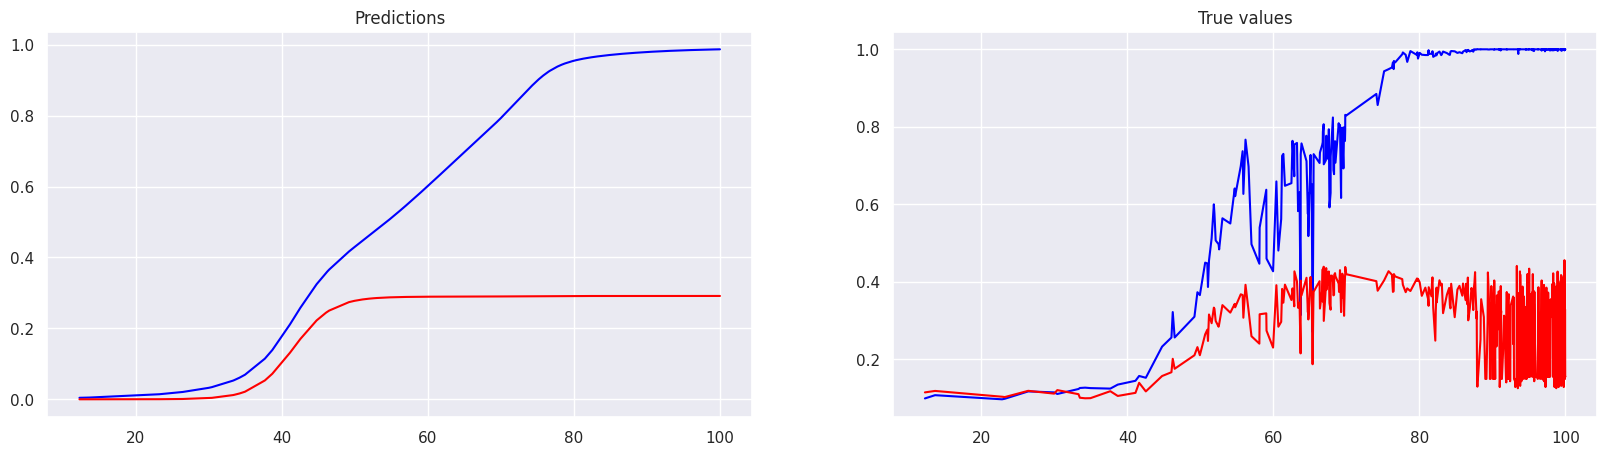

Epoch 201 - loss: 0.012532221153378487
Epoch 202 - loss: 0.012524218298494816
Epoch 203 - loss: 0.012516343966126442
Epoch 204 - loss: 0.012508600950241089
Epoch 205 - loss: 0.012500990182161331
Epoch 206 - loss: 0.012493510730564594
Epoch 207 - loss: 0.012486166320741177
Epoch 208 - loss: 0.01247895136475563
Epoch 209 - loss: 0.012471865862607956
Epoch 210 - loss: 0.012464912608265877
Epoch 211 - loss: 0.012458090670406818
Epoch 212 - loss: 0.012451397255063057
Epoch 213 - loss: 0.012444829568266869
Epoch 214 - loss: 0.012438388541340828
Epoch 215 - loss: 0.01243207324296236
Epoch 216 - loss: 0.012425880879163742
Epoch 217 - loss: 0.01241980865597725
Epoch 218 - loss: 0.012413855642080307
Epoch 219 - loss: 0.012408020906150341
Epoch 220 - loss: 0.012402302585542202
Epoch 221 - loss: 0.012396696954965591
Epoch 222 - loss: 0.012391201220452785
Epoch 223 - loss: 0.01238581445068121
Epoch 224 - loss: 0.01238053198903799
Epoch 225 - loss: 0.012375354766845703
Epoch 226 - loss: 0.0123702790

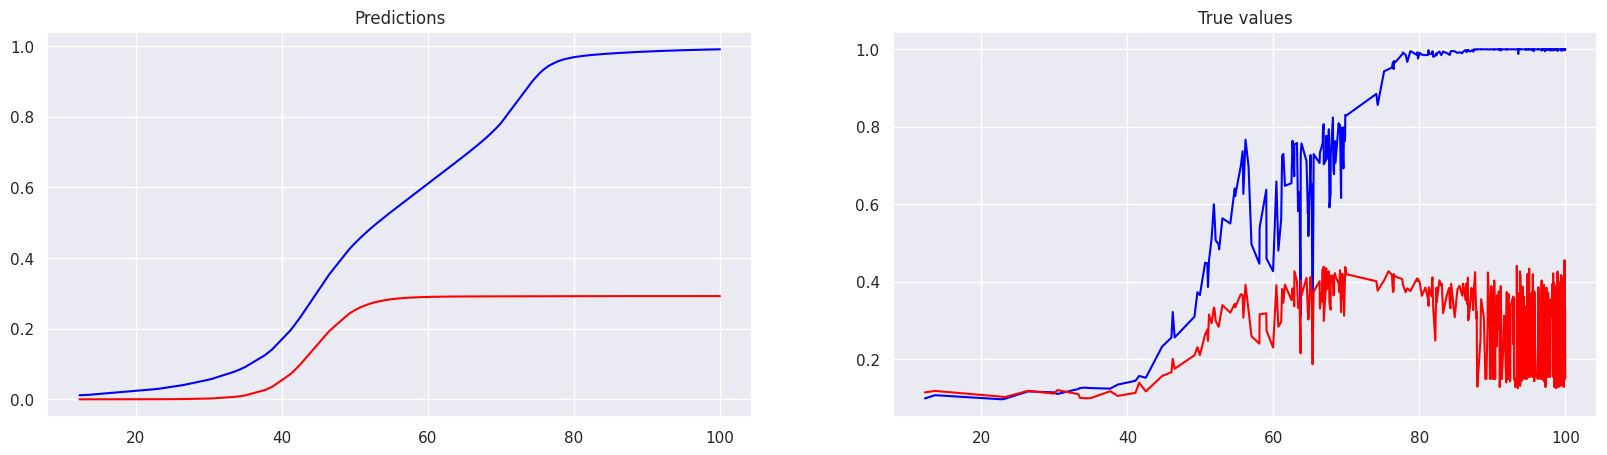

Epoch 301 - loss: 0.01215165015310049
Epoch 302 - loss: 0.012150002643465996
Epoch 303 - loss: 0.012148377485573292
Epoch 304 - loss: 0.012146776542067528
Epoch 305 - loss: 0.012145194225013256
Epoch 306 - loss: 0.012143634259700775
Epoch 307 - loss: 0.012142092920839787
Epoch 308 - loss: 0.01214057207107544
Epoch 309 - loss: 0.012139074504375458
Epoch 310 - loss: 0.01213759183883667
Epoch 311 - loss: 0.012136132456362247
Epoch 312 - loss: 0.012134691700339317
Epoch 313 - loss: 0.012133268639445305
Epoch 314 - loss: 0.012131866067647934
Epoch 315 - loss: 0.012130479328334332
Epoch 316 - loss: 0.01212911307811737
Epoch 317 - loss: 0.012127763591706753
Epoch 318 - loss: 0.012126431800425053
Epoch 319 - loss: 0.012125116772949696
Epoch 320 - loss: 0.01212382223457098
Epoch 321 - loss: 0.012122541666030884
Epoch 322 - loss: 0.012121278792619705
Epoch 323 - loss: 0.012120031751692295
Epoch 324 - loss: 0.012118803337216377
Epoch 325 - loss: 0.01211758516728878
Epoch 326 - loss: 0.01211638562

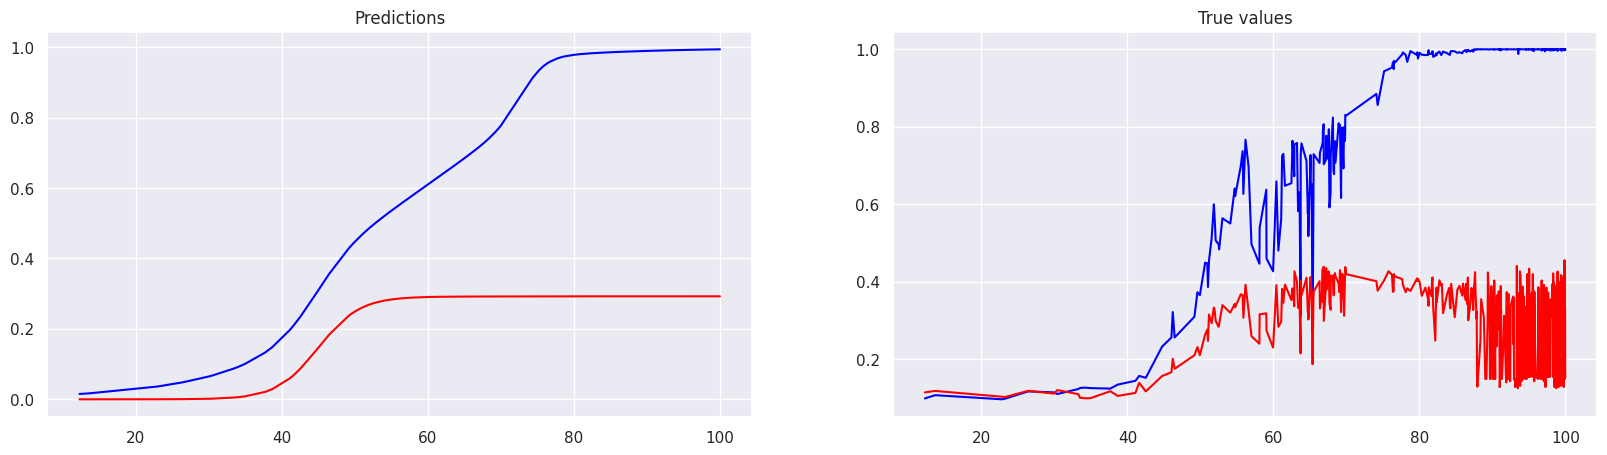

Epoch 401 - loss: 0.012058306485414505
Epoch 402 - loss: 0.012057822197675705
Epoch 403 - loss: 0.012057343497872353
Epoch 404 - loss: 0.012056868523359299
Epoch 405 - loss: 0.012056399136781693
Epoch 406 - loss: 0.01205593440681696
Epoch 407 - loss: 0.0120554743334651
Epoch 408 - loss: 0.012055018916726112
Epoch 409 - loss: 0.012054568156599998
Epoch 410 - loss: 0.012054122984409332
Epoch 411 - loss: 0.012053681537508965
Epoch 412 - loss: 0.012053243815898895
Epoch 413 - loss: 0.012052811682224274
Epoch 414 - loss: 0.012052381411194801
Epoch 415 - loss: 0.012051958590745926
Epoch 416 - loss: 0.012051539495587349
Epoch 417 - loss: 0.012051122263073921
Epoch 418 - loss: 0.012050710618495941
Epoch 419 - loss: 0.01205030269920826
Epoch 420 - loss: 0.012049899436533451
Epoch 421 - loss: 0.01204950176179409
Epoch 422 - loss: 0.012049105018377304
Epoch 423 - loss: 0.012048712000250816
Epoch 424 - loss: 0.012048323638737202
Epoch 425 - loss: 0.012047938071191311
Epoch 426 - loss: 0.0120475571

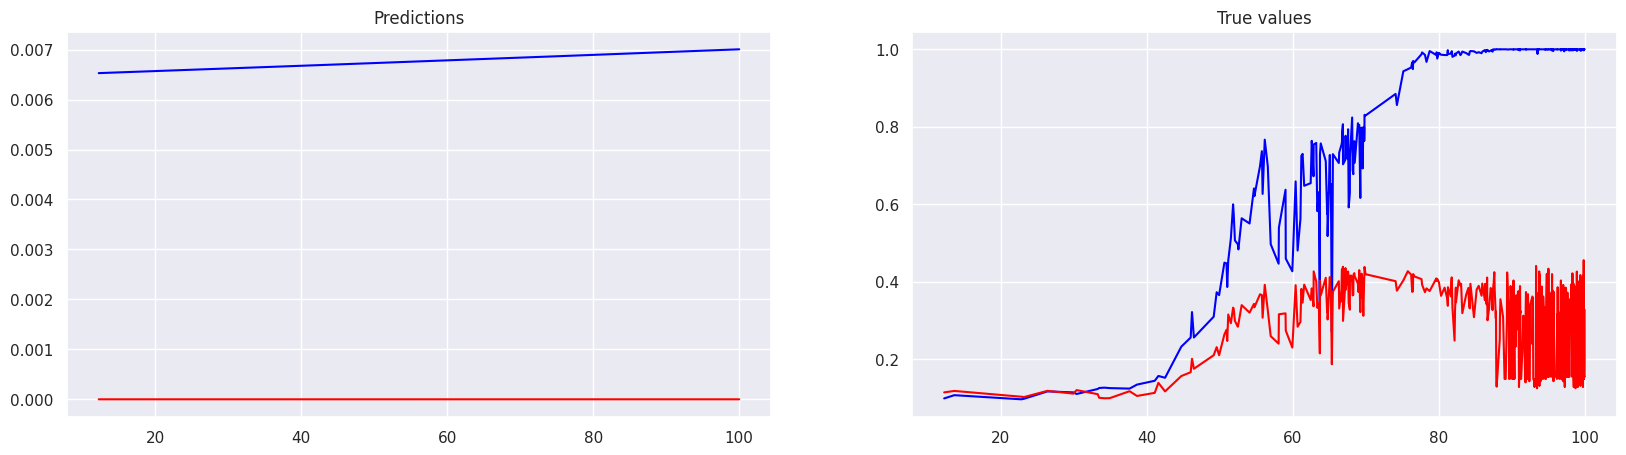

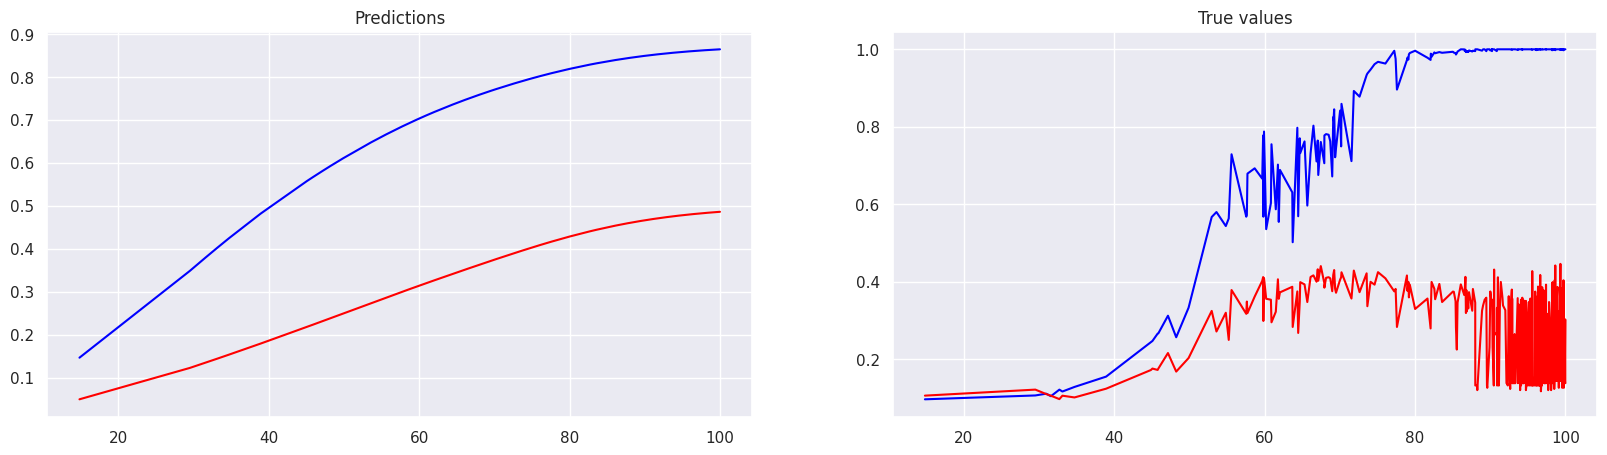

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.07395470142364502


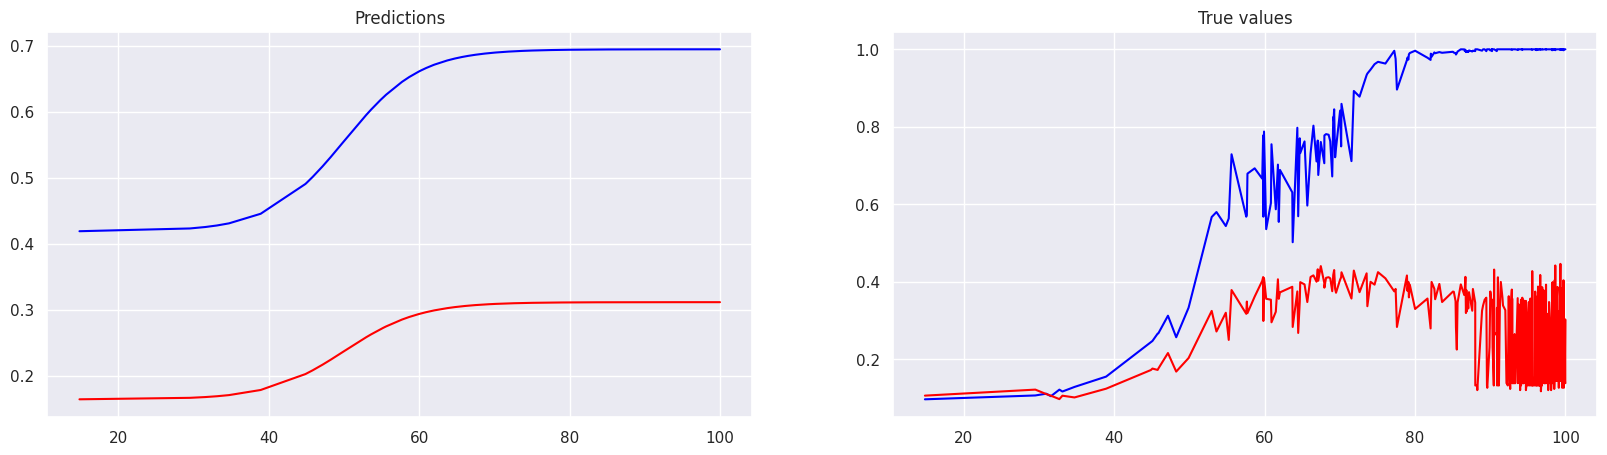

Epoch 1 - loss: 0.09226788580417633
Epoch 2 - loss: 0.06567972153425217
Epoch 3 - loss: 0.06837587058544159
Epoch 4 - loss: 0.06843626499176025
Epoch 5 - loss: 0.06685836613178253
Epoch 6 - loss: 0.06440174579620361
Epoch 7 - loss: 0.06146600842475891
Epoch 8 - loss: 0.05822242796421051
Epoch 9 - loss: 0.054768335074186325
Epoch 10 - loss: 0.05145932734012604
Epoch 11 - loss: 0.049285076558589935
Epoch 12 - loss: 0.0485340841114521
Epoch 13 - loss: 0.04701079800724983
Epoch 14 - loss: 0.0438849963247776
Epoch 15 - loss: 0.040559910237789154
Epoch 16 - loss: 0.03845219686627388
Epoch 17 - loss: 0.037499070167541504
Epoch 18 - loss: 0.03696102276444435
Epoch 19 - loss: 0.03633742779493332
Epoch 20 - loss: 0.03544178605079651
Epoch 21 - loss: 0.03437265381217003
Epoch 22 - loss: 0.033517204225063324
Epoch 23 - loss: 0.033241305500268936
Epoch 24 - loss: 0.03332019969820976
Epoch 25 - loss: 0.03325784206390381
Epoch 26 - loss: 0.03292969614267349
Epoch 27 - loss: 0.03250635415315628
Epoch 

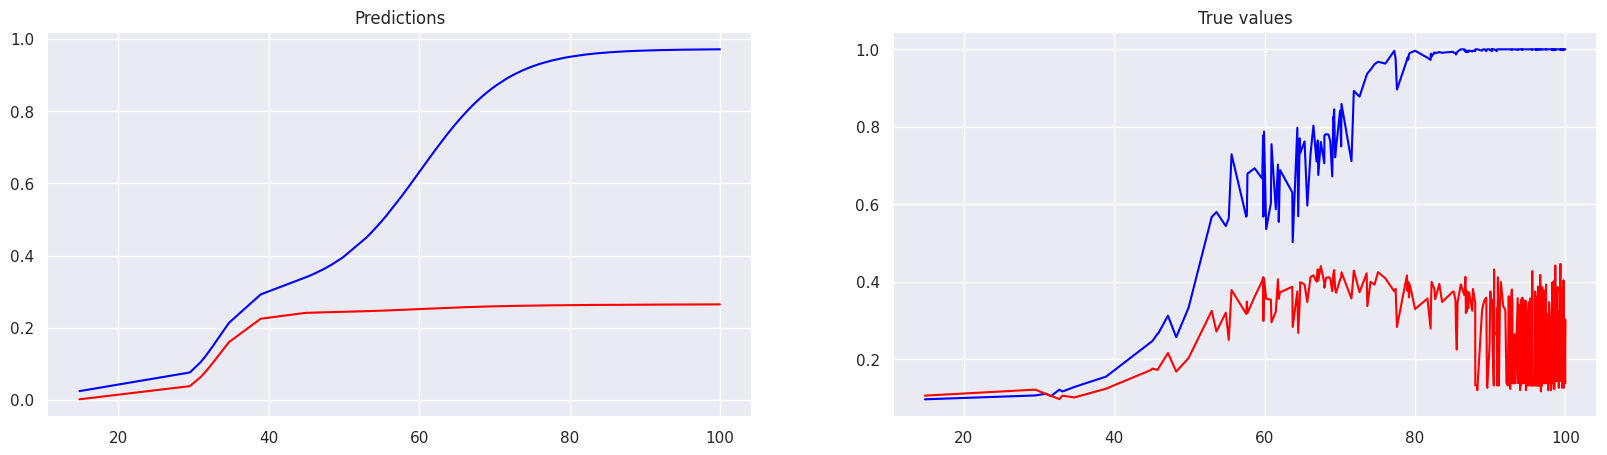

Epoch 101 - loss: 0.015111347660422325
Epoch 102 - loss: 0.015059132128953934
Epoch 103 - loss: 0.01500570960342884
Epoch 104 - loss: 0.01497186254709959
Epoch 105 - loss: 0.01495943870395422
Epoch 106 - loss: 0.014943761751055717
Epoch 107 - loss: 0.014907744713127613
Epoch 108 - loss: 0.01486766804009676
Epoch 109 - loss: 0.014842331409454346
Epoch 110 - loss: 0.014828803949058056
Epoch 111 - loss: 0.01481403037905693
Epoch 112 - loss: 0.014790849760174751
Epoch 113 - loss: 0.014762777835130692
Epoch 114 - loss: 0.01473909430205822
Epoch 115 - loss: 0.014724682085216045
Epoch 116 - loss: 0.014713562093675137
Epoch 117 - loss: 0.014696766622364521
Epoch 118 - loss: 0.014675473794341087
Epoch 119 - loss: 0.014657578431069851
Epoch 120 - loss: 0.01464548334479332
Epoch 121 - loss: 0.014634859748184681
Epoch 122 - loss: 0.014621490612626076
Epoch 123 - loss: 0.014605731703341007
Epoch 124 - loss: 0.014591263607144356
Epoch 125 - loss: 0.014580422081053257
Epoch 126 - loss: 0.014571223407

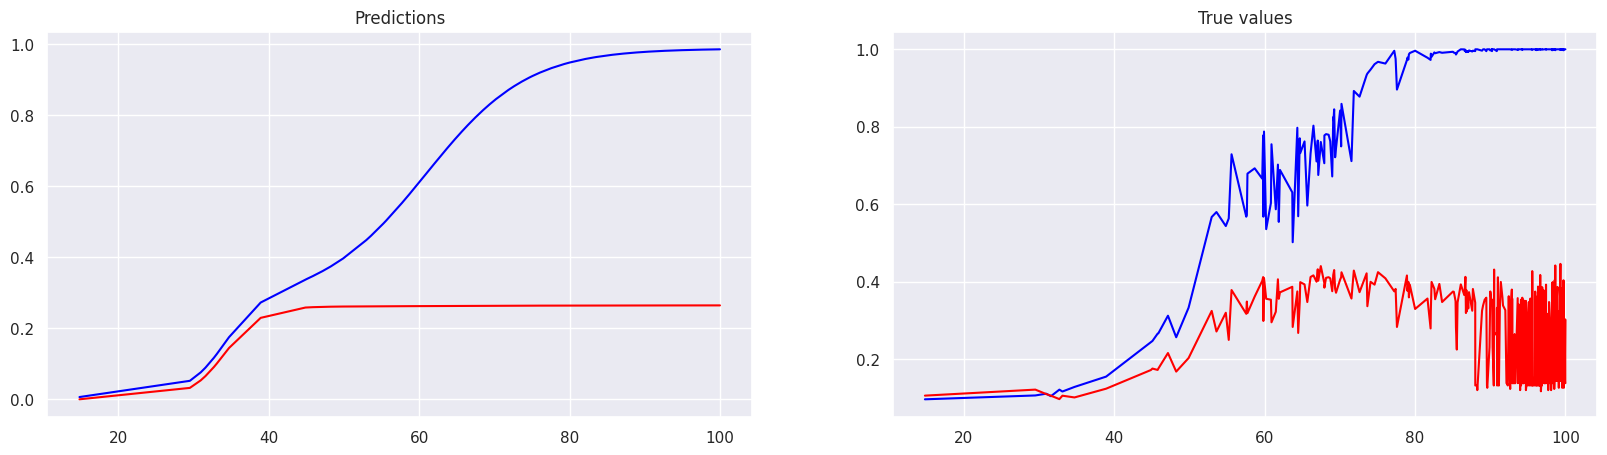

Epoch 201 - loss: 0.014195199124515057
Epoch 202 - loss: 0.014192750677466393
Epoch 203 - loss: 0.014190330170094967
Epoch 204 - loss: 0.014187930151820183
Epoch 205 - loss: 0.014185557141900063
Epoch 206 - loss: 0.014183210209012032
Epoch 207 - loss: 0.014180884696543217
Epoch 208 - loss: 0.014178583398461342
Epoch 209 - loss: 0.014176302589476109
Epoch 210 - loss: 0.01417404506355524
Epoch 211 - loss: 0.014171806164085865
Epoch 212 - loss: 0.014169595204293728
Epoch 213 - loss: 0.014167399145662785
Epoch 214 - loss: 0.014165224507451057
Epoch 215 - loss: 0.014163065701723099
Epoch 216 - loss: 0.01416093111038208
Epoch 217 - loss: 0.014158811420202255
Epoch 218 - loss: 0.014156707562506199
Epoch 219 - loss: 0.014154626056551933
Epoch 220 - loss: 0.014152560383081436
Epoch 221 - loss: 0.014150508679449558
Epoch 222 - loss: 0.014148472808301449
Epoch 223 - loss: 0.014146455563604832
Epoch 224 - loss: 0.014144454151391983
Epoch 225 - loss: 0.014142466709017754
Epoch 226 - loss: 0.0141404

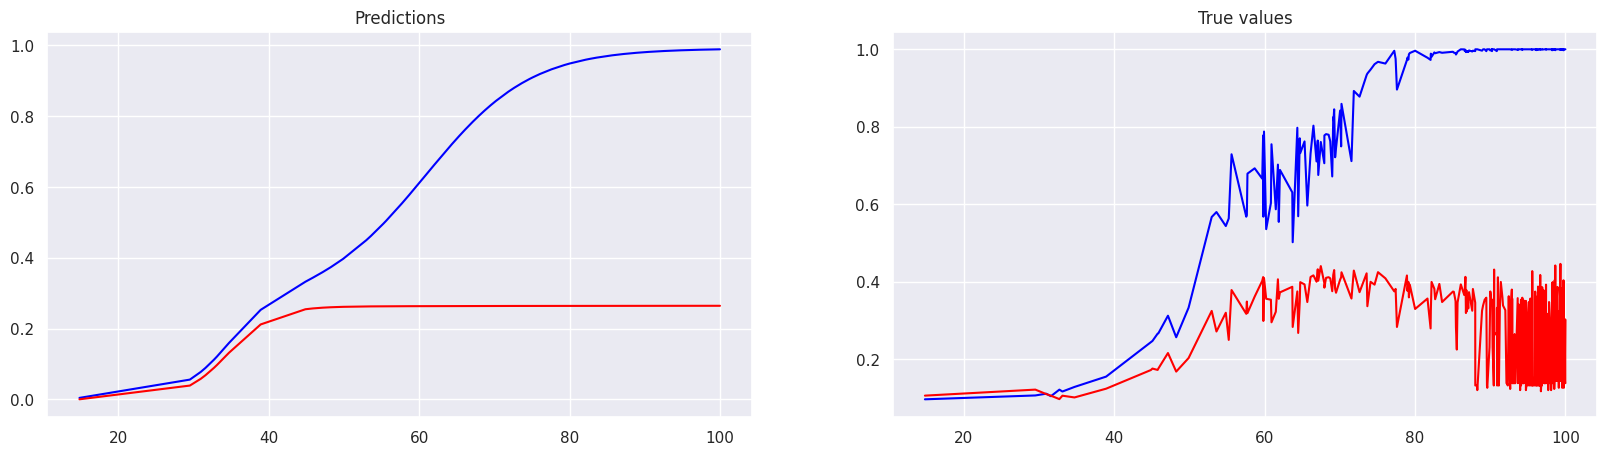

Epoch 301 - loss: 0.014012682251632214
Epoch 302 - loss: 0.014011010527610779
Epoch 303 - loss: 0.014009331353008747
Epoch 304 - loss: 0.014007646590471268
Epoch 305 - loss: 0.01400595623999834
Epoch 306 - loss: 0.014004260301589966
Epoch 307 - loss: 0.014002560637891293
Epoch 308 - loss: 0.014000850729644299
Epoch 309 - loss: 0.01399913989007473
Epoch 310 - loss: 0.013997417874634266
Epoch 311 - loss: 0.01399568933993578
Epoch 312 - loss: 0.013993954285979271
Epoch 313 - loss: 0.01399221271276474
Epoch 314 - loss: 0.013990465551614761
Epoch 315 - loss: 0.013988705351948738
Epoch 316 - loss: 0.013986937701702118
Epoch 317 - loss: 0.013985165394842625
Epoch 318 - loss: 0.01398338284343481
Epoch 319 - loss: 0.013981590047478676
Epoch 320 - loss: 0.01397978886961937
Epoch 321 - loss: 0.013977980241179466
Epoch 322 - loss: 0.013976159505546093
Epoch 323 - loss: 0.013974330388009548
Epoch 324 - loss: 0.013972491025924683
Epoch 325 - loss: 0.013970642350614071
Epoch 326 - loss: 0.01396877970

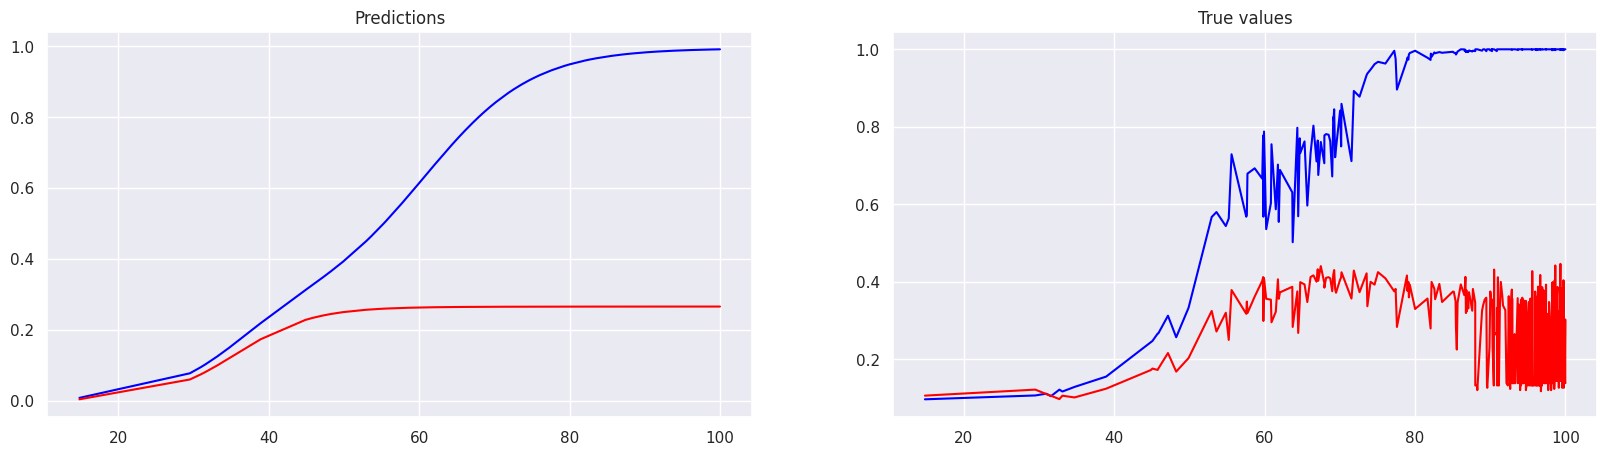

Epoch 401 - loss: 0.013824796304106712
Epoch 402 - loss: 0.013823898509144783
Epoch 403 - loss: 0.013823050074279308
Epoch 404 - loss: 0.013822250068187714
Epoch 405 - loss: 0.013821491971611977
Epoch 406 - loss: 0.013820776715874672
Epoch 407 - loss: 0.013820100575685501
Epoch 408 - loss: 0.01381946075707674
Epoch 409 - loss: 0.013818852603435516
Epoch 410 - loss: 0.013818275183439255
Epoch 411 - loss: 0.013817726634442806
Epoch 412 - loss: 0.013817202299833298
Epoch 413 - loss: 0.013816697522997856
Epoch 414 - loss: 0.013816215097904205
Epoch 415 - loss: 0.013815748505294323
Epoch 416 - loss: 0.013815298676490784
Epoch 417 - loss: 0.013814856298267841
Epoch 418 - loss: 0.013814426958560944
Epoch 419 - loss: 0.013814006932079792
Epoch 420 - loss: 0.013813591562211514
Epoch 421 - loss: 0.013813184574246407
Epoch 422 - loss: 0.013812781311571598
Epoch 423 - loss: 0.013812382705509663
Epoch 424 - loss: 0.013811983168125153
Epoch 425 - loss: 0.013811590149998665
Epoch 426 - loss: 0.013811

In [7]:
for sweep, sweep_id, unique_col in zip(SWEEPS, SWEEP_IDS, UNIQUE_COLS): 
    fit_sweep(sweep, unique_col, num_patterns=3, max_time=100.0, log=True, sweep=sweep_id, num_epochs=500)

In [5]:
api = wandb.Api()
runs = api.runs(f"jqhoogland/fit-toy-model")
[run for run in runs]

[<Run jqhoogland/fit-toy-model/qc4itmz1 (running)>,
 <Run jqhoogland/fit-toy-model/0v1thdzj (finished)>,
 <Run jqhoogland/fit-toy-model/1gthqqg5 (finished)>,
 <Run jqhoogland/fit-toy-model/5s56iliv (crashed)>]

In [26]:
mw_fit_run_id = "1gthqq5"
run = runs[0]
df = run.history()

col = "d_model"
unique_vals = df.loc[:, col].unique()
unique_vals

array([  1,   2,   3,   4,   5,   6,   8,   9,  11,  14,  17,  20,  25,
        30,  37,  44,  54,  65,  79,  95, 115, 140, 169, 205, 248, 300])

In [47]:
D_MODEL = 115

model_entry = df.loc[df[col] == D_MODEL, :].iloc[0, :]
model_entry

pattern_0/onset                   3307.669922
_step                                      20
modulus                                   113
log                                      True
pattern_1/speed                       0.00761
d_vocab                                   114
num_training_steps                     100000
weight_decay                              0.3
_runtime                             2.410218
sweep                                l1b2mmci
pattern_1/onset                   4938.347168
lr                                      0.001
seed                                        0
pattern_1/generalization             0.701577
pattern_2/generalization             6.939834
num_layers                                  1
log_interval                               10
pattern_1/strength                     0.9862
pattern_0/strength                   0.077263
pattern_0/speed                      0.004219
d_model                                   115
pattern_2/strength                

In [50]:
def df_row_to_toy_model(row):
    model = PatternLearningModel(max_time=100.)

    for i, pattern in enumerate(model.patterns):
        pattern.onset.data = torch.tensor(row[f"pattern_{i}/onset"])
        pattern.speed.data = torch.tensor(row[f"pattern_{i}/speed"])
        pattern.strength.data = torch.tensor(row[f"pattern_{i}/strength"])
        pattern.generalization.data = torch.tensor(row[f"pattern_{i}/generalization"])

    return model

model = df_row_to_toy_model(model_entry)
model.rescale(100)
model


PatternLearningModel({'pattern_0/strength': tensor(0.0773, dtype=torch.float64), 'pattern_0/speed': tensor(0.0042, dtype=torch.float64), 'pattern_0/onset': tensor(3307.6699, dtype=torch.float64), 'pattern_0/generalization': tensor(0.0144, dtype=torch.float64), 'pattern_1/strength': tensor(0.9862, dtype=torch.float64), 'pattern_1/speed': tensor(0.0076, dtype=torch.float64), 'pattern_1/onset': tensor(4938.3472, dtype=torch.float64), 'pattern_1/generalization': tensor(0.7016, dtype=torch.float64), 'pattern_2/strength': tensor(0.9925, dtype=torch.float64), 'pattern_2/speed': tensor(0.0058, dtype=torch.float64), 'pattern_2/onset': tensor(7550.4229, dtype=torch.float64), 'pattern_2/generalization': tensor(6.9398, dtype=torch.float64)})

/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'Fit')

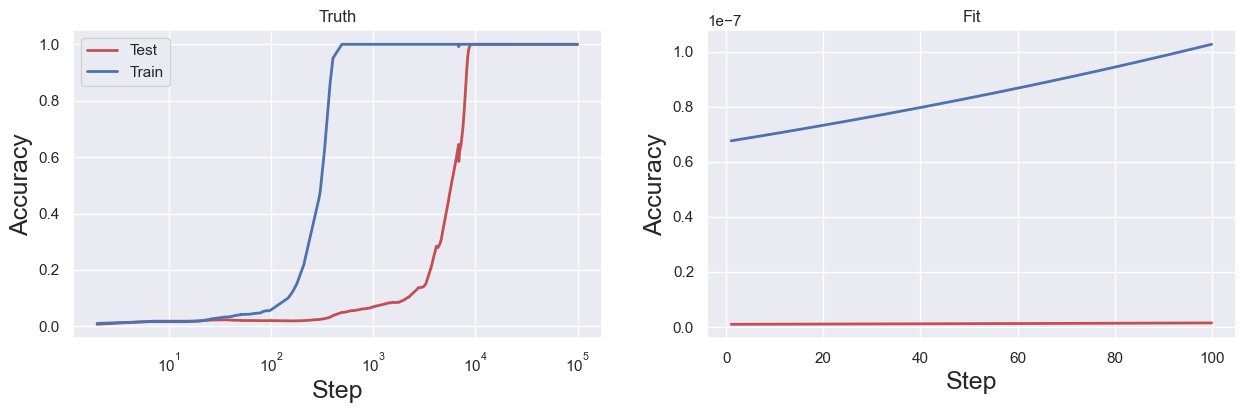

In [51]:
# Get corresponding original run
og_df = get_history(DM_SWEEP_ID, unique_cols="d_model")
run = og_df.loc[og_df.d_model==D_MODEL,:] #.plot(x="_step", y="test/acc")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(run["_step"], run["test/acc"], label="Test", color=RED, linewidth=2)
ax1.plot(run["_step"], run["train/acc"], label="Train", color=BLUE, linewidth=2)
ax1.set_ylabel("Accuracy", fontsize=18)
ax1.set_xlabel("Step", fontsize=18)
ax1.set_xscale("log")
ax1.legend()
ax1.set_title("Truth")

min_step, max_step = og_df["_step"].min(), 10000 # run["_step"].max()

ts = np.linspace(min_step, max_step, 1000)
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax2.plot(ts, train_ys, label="Train", color=BLUE, linewidth=2)
ax2.plot(ts, test_ys, label="Test", color=RED, linewidth=2)
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Step", fontsize=18)
ax2.set_title("Fit")

# Already in log scale
# train_ys, test_ys

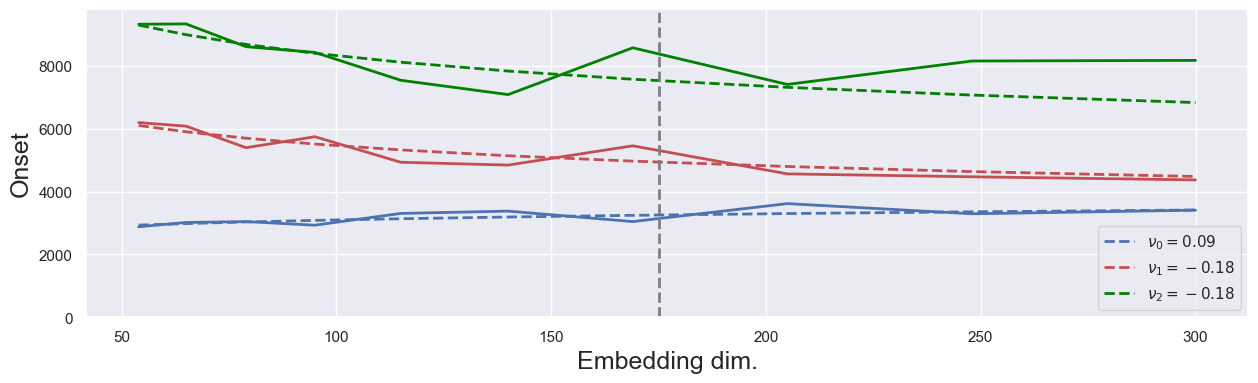

In [70]:
# Ignore any d_model < 50
df_cleaned = df.loc[df["d_model"] >= 50, :]
d_models = df_cleaned.loc[:, "d_model"].unique()

# Scaling analysis
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

colors = [BLUE, RED, "green"]
y_max = 0

for i in range(3):
    slice = df_cleaned.loc[:, f"pattern_{i}/onset"]
    y_max = max(y_max, slice.max())
    ax.plot(d_models, slice, label=f"", color=colors[i], linewidth=2)

ax.set_xlabel("d_model", fontsize=18)
ax.set_ylabel("Onset", fontsize=18)


# Fit a power-law to the onsets 
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x**b

def fit_power_law(x, y):
    popt, pcov = curve_fit(power_law, x, y)
    return popt


CUTOFF = 175

# Fit power law to onset
for i in range(3):
    # Train up to a specific point
    df_to_fit = df_cleaned.loc[df_cleaned["d_model"] <= CUTOFF, :]
    d_models_to_fit = df_to_fit.loc[:, "d_model"].unique()

    onset_popt = fit_power_law(d_models_to_fit, df_to_fit.loc[:, f"pattern_{i}/onset"])
    exponent = round(onset_popt[1], 2)
    ax.plot(d_models, power_law(d_models, *onset_popt), label=f"$\\nu_{i} = {exponent}$", color=colors[i], linestyle="--", linewidth=2)

ax.vlines(CUTOFF, 0, y_max * 1.05, color="grey", linestyle="--", linewidth=2)
ax.set_xlabel("Embedding dim.", fontsize=18)
ax.set_ylim(0, y_max * 1.05)

ax.legend()

In [ ]:
# Let's see if we can fit 